In [2]:
import sys; print(sys.executable)  # sanity: shows which Python your kernel uses
%pip install --upgrade pip
%pip install scipy seaborn


/Users/user/.venvs/main/bin/python
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.6/23.6 MB 10.2 MB/s  0:00:02 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 13.3 MB/s  0:00:00 eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5/5 [seaborn]m4/5 [seaborn]
Note: you may need to restart the kernel to use updated packages.


In [30]:
import numpy as np
from scipy.integrate import quad
from scipy.optimize import fsolve
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import time
from scipy.optimize import minimize
from scipy.integrate import IntegrationWarning
from scipy.integrate import quad, simpson
import warnings
import seaborn as sns

warnings.filterwarnings("ignore")

# Configure matplotlib to use the pgf backend
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",  # Change this if using xelatex or lualatex
    "text.usetex": True,          # Use LaTeX to write all text
    "font.family": "serif",
    "axes.labelsize": 25,         # LaTeX default is 10pt font.
    "font.size": 20,
    "legend.fontsize": 20,
    "xtick.labelsize": 25,
    "ytick.labelsize": 25,
    "axes.titlesize": 30, 
    "pgf.preamble": r"""
        \usepackage[utf8]{inputenc}    # Use UTF8 input encoding
        \usepackage[T1]{fontenc}       # Use T1 fonts
        \usepackage{amsmath}           # For math
    """
})

# Constants
delta_0_star_initial, delta_1_star_initial =0.47716112847660036, 0.11112649047308443
f=0.0048366897
s = 0.6884162140
r = 0.0361577940
gamma=0.0867540457
rho =0.4133277998
lambda1 =3.9750228339
delta_bar = 1
N_points = 101
delta_grid = np.linspace(0, delta_bar, N_points)
f,gamma,rho,lambda1,delta_0_star_initial, delta_1_star_initial=0.021,0.07,0.3,3,0.483672706,0.106481650304695

delta_bar = 1
N_points = 101
delta_grid = np.linspace(0, delta_bar, N_points)
grid_spacing = delta_grid[1] - delta_grid[0]

fixed_params = {
    'f': f,
    's': s,
    'r': r,
    'gamma': gamma,
    'rho': rho,
    'lambda1': lambda1
}

In [31]:
# Define the case functions for H1
def H1_case_C(delta, F1_val, r, gamma, s, f, lambda1, rho):
    a = rho
    b = lambda1 * (f - F1_val) + gamma * (1 - delta) + rho * (1 - delta - s + F1_val) + gamma * delta
    c = -gamma * delta * (s - F1_val)
    discriminant = b**2 - 4 * a * c
    if a == 0:
        H1_delta = -c / b
    elif discriminant >= 0:
        H1_delta = (-b + np.sqrt(discriminant)) / (2 * a)
    else:
        H1_delta = (-b) / (2 * a)  # Fallback: Use the midpoint formula when discriminant is negative
    return H1_delta

def H1_case_D(delta, H1_delta1, F1_val, r, gamma, s, f, lambda1, rho):
    a = rho
    b = gamma * (1 - delta) + rho * (1 - delta - s + F1_val) + gamma * delta
    c = -gamma * delta * (s - F1_val) + lambda1 * (f - F1_val) * H1_delta1
    discriminant = b**2 - 4 * a * c
    if a == 0:
        H1_delta = -c / b
    elif discriminant >= 0:
        H1_delta = (-b + np.sqrt(discriminant)) / (2 * a)
    else:
        H1_delta = (-b) / (2 * a)  # Fallback: Use the midpoint formula when discriminant is negative
    return H1_delta

def H1_case_E(delta, H1_delta0, F1_val, r, gamma, s, f, lambda1, rho, H1_delta1, delta_0_star):
    a = rho
    b = gamma * (1 - delta) + rho * (1 - delta - s + F1_val) + lambda1 * F1_val + gamma * delta
    c = - (lambda1 * F1_val * (delta - delta_0_star + H1_delta0) + gamma * delta * (s - F1_val) - lambda1 * (f - F1_val) * H1_delta1)
    discriminant = b**2 - 4 * a * c
    if a == 0:
        H1_delta = -c / b
    elif discriminant >= 0:
        H1_delta = (-b + np.sqrt(discriminant)) / (2 * a)
    else:
        H1_delta = (-b) / (2 * a)  # Fallback: Use the midpoint formula when discriminant is negative
    return H1_delta

# Helper functions for H1 and H0 computations
def H1_delta1_comp(F1_val, r, gamma, s, f, lambda1, rho, delta_1_star):
    a = rho
    b = lambda1 * (f - F1_val) + gamma * (1 - delta_1_star) + rho * (1 - delta_1_star - s + F1_val) + gamma * delta_1_star
    c = -gamma * delta_1_star * (s - F1_val)
    if a == 0:
        H1_delta1 = -c / b
    else:
        discriminant = b**2 - 4 * a * c
        if discriminant < 0:
            raise ValueError("Negative discriminant in quadratic equation.")
        H1_delta1 = (-b + np.sqrt(discriminant)) / (2 * a)
    return H1_delta1

def H1_delta0_comp(F1_val, H1_delta1, r, gamma, s, f, lambda1, rho, delta_0_star):
    a = rho
    b = gamma * (1 - delta_0_star) + rho * (1 - delta_0_star - s + F1_val) + gamma * delta_0_star
    c = -gamma * delta_0_star * (s - F1_val) + lambda1 * (f - F1_val) * H1_delta1
    if a == 0:
        H1_delta0 = -c / b
    else:
        discriminant = b**2 - 4 * a * c
        if discriminant < 0:
            raise ValueError("Negative discriminant in quadratic equation.")
        H1_delta0 = (-b + np.sqrt(discriminant)) / (2 * a)
    return H1_delta0

def trade_condition(F1_val, r, gamma, s, f, lambda1, rho, delta_1_star, delta_0_star):
    H1_delta1 = H1_delta1_comp(F1_val, r, gamma, s, f, lambda1, rho, delta_1_star)
    H1_delta0 = H1_delta0_comp(F1_val, H1_delta1, r, gamma, s, f, lambda1, rho, delta_0_star)
    left_side = F1_val * (1 - delta_0_star - s + F1_val + H1_delta0)
    right_side = (f - F1_val) * H1_delta1
    return left_side - right_side

# Solver for F1
def solve_F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    F1_initial = f
    F1_solution = fsolve(trade_condition, F1_initial, args=(r, gamma, s, f, lambda1, rho, delta_1_star, delta_0_star))
    return F1_solution[0]

def F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    return solve_F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

def F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    return f - F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

def H1(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho):
    # Compute the transition values to ensure continuity
    H1_delta1 = H1_case_C(delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    H1_delta0 = H1_case_D(delta_0_star, H1_delta1, F1_val, r, gamma, s, f, lambda1, rho)
    
    if 0 < delta <= delta_1_star:
        return H1_case_C(delta, F1_val, r, gamma, s, f, lambda1, rho)
    elif delta_1_star < delta < delta_0_star:
        return H1_case_D(delta, H1_delta1, F1_val, r, gamma, s, f, lambda1, rho)
    elif delta_0_star <= delta <= 1:
        return H1_case_E(delta, H1_delta0, F1_val, r, gamma, s, f, lambda1, rho, H1_delta1, delta_0_star)
    else:
        return 0  # Fallback to avoid returning None

def H0(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho):
    if 0 < delta <= 1:
        return delta - H1(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    else:
        return 0

def compute_H_values(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    H1_values = []
    H0_values = []

    for delta in delta_grid:
        
        H1_val = H1(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
        H0_val = H0(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
        # Check for None, NaN, or other invalid values
        if H1_val is None or np.isnan(H1_val):
            H1_val = 0  # Or some other default or error-handling value
        if H0_val is None or np.isnan(H0_val):
            H0_val = 0  # Or some other default or error-handling value
        
        H1_values.append(H1_val)
        H0_values.append(H0_val)

    return np.array(H1_values), np.array(H0_values)

def dH1(delta, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

    H1_val = H1(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)

    if 0 <= delta <= delta_1_star:
        b = lambda1 * F0_val + gamma + rho * (1 - delta - s + F1_val + 2 * H1_val)
        c = gamma * (s - F1_val) + rho * H1_val
    elif delta_1_star < delta < delta_0_star:
        b = gamma + rho * (1 - delta - s + F1_val + 2 * H1_val)
        c = gamma * (s - F1_val) + rho * H1_val
    elif delta >= delta_0_star:
        b = lambda1 * F1_val + gamma + rho * (1 - delta - s + F1_val + 2 * H1_val)
        c = lambda1 * F1_val + gamma * (s - F1_val) + rho * H1_val
    else:
        return 0

    return c / b
def dH0(delta, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    return 1 - dH1(delta, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

def dH1_gen(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    H1_values, H0_values = compute_H_values(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

    dH1_values = np.zeros_like(delta_grid)
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    
    for i, delta in enumerate(delta_grid):
        H1_delta = H1_values[i]
        
        if 0 <= delta <= delta_1_star:
            a = 0
            b = lambda1 * F0_val + gamma + rho * (1 - delta - s + F1_val + 2 * H1_delta)
            c = gamma * (s - F1_val) + rho * H1_delta
        elif delta_1_star < delta < delta_0_star:
            a = 0
            b = gamma + rho * (1 - delta - s + F1_val + 2 * H1_delta)
            c = gamma * (s - F1_val) + rho * H1_delta
        elif delta >= delta_0_star:
            a = 0
            b = lambda1 * F1_val + gamma + rho * (1 - delta - s + F1_val + 2 * H1_delta)
            c = lambda1 * F1_val + gamma * (s - F1_val) + rho * H1_delta
        else:
            dH1_values[i] = 0  # or some default value
            continue  # Skip to the next iteration to avoid unintended behavior
        
        if b != 0:  # To avoid division by zero
            dH1_values[i] = c / b
        else:
            dH1_values[i] = 0  # Handle the special case where b is zero
        
    return np.array(dH1_values)



def dH0_gen(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    
    # Simply return 1 - dH1_gen, which will be an array
    return 1 - dH1_gen(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)


def dH0Delta(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    H1_values, H0_values = compute_H_values(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH0_values = dH0_gen(  delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH1_values = dH1_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

    n = len(delta_grid)
    dH0Delta_matrix = np.zeros((n, n))  # Create an n x n matrix filled with zeros
    for i in range(n - 1):
        dH0Delta_matrix[i, i + 1:] = dH0_values[i + 1:] * grid_spacing  # Use the array values here
    return dH0Delta_matrix

def dH1Delta(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    H1_values, H0_values = compute_H_values(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH0_values = dH0_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH1_values = dH1_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

    n = len(delta_grid)
    dH1Delta_matrix = np.zeros((n, n))  # Create an n x n matrix filled with zeros
    for i in range(1, n):
        dH1Delta_matrix[i, :i] = dH1_values[:i] * grid_spacing  # Use the array values here
    return dH1Delta_matrix

def Sigma(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = f - F1_val

    sigma_values = np.zeros_like(delta_grid)
    H0_1 = H0(1.0, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    
    for i, delta in enumerate(delta_grid):
        H0_delta = H0(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
        H1_delta = H1(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
        
        if delta < delta_1_star:
            sigma_values[i] = r + gamma + lambda1 * F0_val + (rho / 2) * (H0_1 - H0_delta) + (rho / 2) * H1_delta
        elif delta_1_star <= delta <= delta_0_star:
            sigma_values[i] = r + gamma + (rho / 2) * (H0_1 - H0_delta) + (rho / 2) * H1_delta
        elif delta > delta_0_star:
            sigma_values[i] = r + gamma + lambda1 * F1_val + (rho / 2) * (H0_1 - H0_delta) + (rho / 2) * H1_delta
    return np.diag(sigma_values)

def dG_outer_1T(delta_grid,r, gamma, s, f, lambda1, rho):
    dG = np.full_like(delta_grid, 1 / len(delta_grid))
    return np.outer(dG, np.ones_like(delta_grid))

def W1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    # Define the continuous functions
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    
    # Calculate necessary values using continuous functions
    H0_1 = H0(1.0, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    H0_delta0_star = H0(delta_0_star, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    H1_delta0_star = H1(delta_0_star, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    
    sigma_delta0 = r + gamma + (rho / 2) * (H0_1 - H0_delta0_star) + (rho / 2) * H1_delta0_star
    

    # Integrate dH0 from delta_0_star to 1
    dH0_delta0 = dH0(delta_0_star, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    
    if dH0_delta0 == 0:
        dH0_delta0=0.0000001
    
    return (lambda1 / r) * (H0_1 - H0_delta0_star)**2 / (sigma_delta0 * dH0_delta0)

def W0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho):
    # Define the continuous functions
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
        
    # Calculate necessary values using continuous functions
    H0_1 = H0(1.0, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    H0_delta1_star = H0(delta_1_star, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    H1_delta1_star = H1(delta_1_star, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)
    
    sigma_delta1 = r + gamma + (rho / 2) * (H0_1 - H0_delta1_star) + (rho / 2) * H1_delta1_star

    # Integrate dH1 from delta_1_star to 0
    dH1_delta1 = dH1(delta_1_star, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    
    if dH1_delta1 == 0:
        dH1_delta1=0.0000001
    
    return (lambda1 / r) * H1_delta1_star**2 / (sigma_delta1 * dH1_delta1)

def value_iteration(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho, max_iterations=3000, tolerance=1e-10):
    # Initialize the vector for \Delta V
    X_n = np.zeros_like(delta_grid)
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = f - F1_val
    # Compute H1_values and H0_values as arrays
    H1_values, H0_values = compute_H_values(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

    # Initialize dH0_values and dH1_values as arrays by using the _gen functions
    dH0_values = dH0_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH1_values = dH1_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

    # Now pass these arrays to the next functions
    dH0Delta_matrix = dH0Delta(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH1Delta_matrix = dH1Delta(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    
    Sigma_matrix = Sigma(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dG_outer_1T_matrix = dG_outer_1T(delta_grid,r, gamma, s, f, lambda1, rho)
    
    delta_1_index = np.argmin(np.abs(delta_grid - delta_1_star))
    delta_0_index = np.argmin(np.abs(delta_grid - delta_0_star))
     
    matrix_1 = np.array([[1 if j == delta_1_index and i < delta_1_index else 0 for j in range(len(delta_grid))] for i in range(len(delta_grid))])
    matrix_0 = np.array([[1 if j == delta_0_index and i > delta_0_index else 0 for j in range(len(delta_grid))] for i in range(len(delta_grid))])

    for iteration in range(max_iterations):
        X_n_old = X_n.copy()
        
        Y = delta_grid
        indicator_delta_1 = np.where(delta_grid < delta_1_star, 1, 0)
        indicator_delta_0 = np.where(delta_grid > delta_0_star, 1, 0)
        
        #RHS = Y + lambda1 * F0_val * X_n[delta_1_index] * indicator_delta_1 + lambda1 * F1_val * X_n[delta_0_index] * indicator_delta_0
        
        #matrix_to_invert = Sigma_matrix - gamma * dG_outer_1T_matrix - (rho / 2) * dH0Delta_matrix - (rho / 2) * dH1Delta_matrix
        RHS = Y + lambda1 * F0_val * X_n[delta_1_index] * indicator_delta_1 + lambda1 * F1_val * X_n[delta_0_index] * indicator_delta_0
        
        matrix_to_invert = Sigma_matrix - gamma * dG_outer_1T_matrix - (rho / 2) * dH0Delta_matrix - (rho / 2) * dH1Delta_matrix
        
        matrix_inv = np.linalg.inv(matrix_to_invert)
        
        X_n = np.dot(matrix_inv, RHS)
        
        if np.max(np.abs(X_n - X_n_old)) < tolerance:
            break
    
    return X_n, matrix_to_invert

def find_optimal_deltas_iterative(r, gamma, s, f, lambda1, rho, delta_grid, delta_0_star_initial, 
                                  delta_1_star_initial, chi=0.03,tolerance= 1e-3):
    max_iterations = 3000
    #tolerance = 1e-3
    chi = min(r / lambda1 if rho != 0 else r / lambda1, 1 / gamma)
    chi=0.03
    start_time = time.time()
    delta_0_star = max(delta_0_star_initial, delta_1_star_initial)
    delta_1_star = min(delta_1_star_initial, delta_0_star_initial)
    
    for outer_iteration in range(max_iterations):
        Delta_V, matrix_to_invert = value_iteration(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

        Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")

        Sigma_matrix = Sigma(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

        W_0 = W0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
        W_1 = W1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)

        H0_1 = H0(1.0, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)
        H0_delta0_star = H0(delta_0_star, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)
        H1_delta0_star = H1(delta_0_star, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)
        H0_delta1_star = H0(delta_1_star, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)
        H1_delta1_star = H1(delta_1_star, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)

        sigma_delta0 = r + gamma + (rho / 2) * (H0_1 - H0_delta0_star) + (rho / 2) * H1_delta0_star
        sigma_delta1 = r + gamma + (rho / 2) * (H0_1 - H0_delta1_star) + (rho / 2) * H1_delta1_star

        int1_delta0 = quad(lambda delta: Delta_V_interp(delta) * dH0(delta, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), delta_0_star, 1)[0]
        int2_delta0 = quad(lambda delta: Delta_V_interp(delta) * dH1(delta, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), 0, delta_0_star)[0]
        int3_delta0 = np.mean(Delta_V)
        
        int1_delta1 = quad(lambda delta: Delta_V_interp(delta) * dH0(delta, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), delta_1_star, 1)[0]
        int2_delta1 = quad(lambda delta: Delta_V_interp(delta) * dH1(delta, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), 0, delta_1_star)[0]
        int3_delta1 = np.mean(Delta_V)
        if H0_1 - H0_delta0_star==0:
            H0_delta0_star=0.0000001+H0_1
        if H1_delta1_star==0:
            H1_delta1_star=0.0000001
             
        delta_0_star_new = sigma_delta0 * ((1 + r / (lambda1 * (H0_1 - H0_delta0_star))) * W_1 - W_0) - (rho / 2) * int1_delta0 - (rho / 2) * int2_delta0 - gamma * int3_delta0
        delta_1_star_new = sigma_delta1 * (W_1 - (1 + r / (lambda1 * H1_delta1_star)) * W_0) - (rho / 2) * int1_delta1 - (rho / 2) * int2_delta1 - gamma * int3_delta1
         # Clamp delta_0_star_new and delta_1_star_new within [0, 1]
        delta_0_star_new = min(max(delta_0_star_new, 0), 1)
        delta_1_star_new = min(max(delta_1_star_new, 0), 1)
        #print(f"Iteration {outer_iteration}: delta_0_star_new = {delta_0_star_new}, delta_1_star_new = {delta_1_star_new}")
       
        if abs(delta_0_star_new - delta_0_star) < tolerance and abs(delta_1_star_new - delta_1_star) < tolerance:
            return delta_0_star, delta_1_star
        delta_0_star = chi * delta_0_star_new + (1 - chi) * delta_0_star
        delta_1_star = chi * delta_1_star_new + (1 - chi) * delta_1_star
        #print(f"Iteration {outer_iteration}: Updated delta_0_star = {delta_0_star}, Updated delta_1_star = {delta_1_star}")

    end_time = time.time()
    time_taken = end_time - start_time

    print(f'Cutoffs Converged in {outer_iteration} iterations')
    print(f'Time taken to converge: {time_taken:.2f} seconds')
    print(f'Final delta_0_star: {delta_0_star}, Final delta_1_star: {delta_1_star}')

    return delta_0_star, delta_1_star

# Calculate P(δ, δ')
def P(delta, delta_prime, Delta_V_interp):
    return 0.5 * Delta_V_interp(delta) + 0.5 * Delta_V_interp(delta_prime)


# Calculate P0 and P1
def P0(Delta_V_interp, delta_1_star):
    return Delta_V_interp(delta_1_star)

def P1(Delta_V_interp, delta_0_star):
    return Delta_V_interp(delta_0_star)

In [35]:
start_time = time.time()


optimal_delta_0_star, optimal_delta_1_star = find_optimal_deltas_iterative(r, gamma, s, f, lambda1, rho, delta_grid, 
                                                                           delta_0_star_initial, delta_1_star_initial,
                                                                              tolerance=1e-4)
print("Optimal delta_0_star:", optimal_delta_0_star)
print("Optimal delta_1_star:", optimal_delta_1_star)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total time for operations: {elapsed_time:.2f} seconds")


Optimal delta_0_star: 0.48399476483016973
Optimal delta_1_star: 0.10595324126107726
Total time for operations: 302.62 seconds


In [11]:
import seaborn as sns
import matplotlib.colors as mcolors
# Function to generate the plots
def plot_value_dh_functions(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho, delta_grid):
    Delta_V, matrix_to_invert = value_iteration(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    delta_star = 1 - s
    # Calculate the derivative of Delta V
    Delta_V_prime = np.gradient(Delta_V, delta_grid)
    
    # Calculate Sigma matrix
    Sigma_matrix = Sigma(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    
    H1_values, H0_values = compute_H_values(delta_grid, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    
    # Compute H values as arrays
    H1_values_array = np.array([H1(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho) for delta in delta_grid])
    H0_values_array = np.array([H0(delta, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho) for delta in delta_grid])
    
    # Compute dH values
    dH1_values = dH1_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH0_values = dH0_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    delta_star = 1 - s
      # Calculate excess trade intensity directly using H1, H0, F1_val, and F0_val
    #excess_trade_buyers = rho * H1_values_array - (lambda1 * F1_val * (delta_grid < delta_star))
    #excess_trade_sellers = rho * (H0_values_array[-1] - H0_values_array) - (lambda1 * F0_val * (delta_grid > delta_star))
    # Calculate excess trade intensity
    excess_trade_buyers = rho * H1_values_array - (lambda1 * F1_val * (delta_grid > delta_0_star))
    excess_trade_sellers = rho * (H0_values_array[-1] - H0_values_array) - (lambda1 * F0_val * (delta_grid < delta_1_star))
    print('flippers rates 0,1:',lambda1*(H0(1.0, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)-H0(delta_0_star, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)),lambda1*H1(delta_1_star, delta_0_star, delta_1_star, F1_val, r, gamma, s, f, lambda1, rho)) 
    # Plot Delta V
    plt.figure(figsize=(12, 8))
    plt.plot(delta_grid, Delta_V,color='black', label='$\Delta V(\delta)$', linewidth=5)
    plt.axvline(x=delta_0_star, color='green', linestyle='--', linewidth=2, label='$\delta_0^*$')
    plt.axvline(x=delta_1_star, color='red', linestyle='--', linewidth=2, label='$\delta_1^*$')
    plt.xlabel('$\delta$')
    plt.ylabel('$\Delta V$')
    plt.legend()
    #plt.title('$\Delta V(\delta)$ Convergence')
    #plt.grid(True)
    plt.tight_layout()
    output_path = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f1.pdf"
    plt.savefig(output_path, format='pdf')
    plt.show()

    # Plot inverse of Delta V' and Sigma
    plt.figure(figsize=(12, 8))
    #plt.plot(delta_grid, 1/Delta_V_prime, color='black',label='$1 / \Delta V\'(\delta)$', linestyle='--', linewidth=5)
    plt.plot(delta_grid, np.diag(Sigma_matrix),color='black', label='$\sigma(\delta)$', linestyle='-', linewidth=5)
    plt.axvline(x=delta_0_star, color='green', linestyle='--', linewidth=2, label='$\delta_0^*$')
    plt.axvline(x=delta_1_star, color='red', linestyle='--', linewidth=2, label='$\delta_1^*$')
    plt.xlabel('$\delta$')
    plt.ylabel('Value')
    plt.legend()
    #plt.title('Inverse of $\Delta V\'(\delta)$ and $\sigma(\delta)$')
    #plt.grid(True)
    plt.tight_layout()
    output_path = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f1a.pdf"
    plt.savefig(output_path, format='pdf')
    plt.show()
    inverse_Delta_V_prime = 1 / Delta_V_prime
    print('Minimum at',delta_grid[np.argmin(inverse_Delta_V_prime)])
    # Plot CDFs
    plt.figure(figsize=(12, 8))
    plt.plot(delta_grid, H1_values, label='$H(1, \delta)$', linewidth=5)
    plt.plot(delta_grid, H0_values, label='$H(0, \delta)$', linewidth=5)
    plt.axvline(x=delta_0_star, color='green', linestyle='--', linewidth=2, label='$\delta_0^*$')
    plt.axvline(x=delta_1_star, color='red', linestyle='--', linewidth=2, label='$\delta_1^*$')
    plt.xlabel('$\delta$')
    plt.ylabel('$H$')
    plt.legend()
    #plt.title('CDF Functions $H(1, \delta)$ and $H(0, \delta)$')
    #plt.grid(True)
    plt.tight_layout()
    output_path = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f2.pdf"
    plt.savefig(output_path, format='pdf')
    plt.show()

    # Plot PDFs
    plt.figure(figsize=(12, 8))
    plt.plot(delta_grid, dH1_values, label='$dH(1, \delta)$', linewidth=5)
    plt.plot(delta_grid, dH0_values, label='$dH(0, \delta)$', linewidth=5)
    plt.axvline(x=delta_0_star, color='green', linestyle='--', linewidth=2, label='$\delta_0^*$')
    plt.axvline(x=delta_1_star, color='red', linestyle='--', linewidth=2, label='$\delta_1^*$')
    plt.xlabel('$\delta$')
    plt.ylabel('$dH$')
    plt.legend()
    #plt.title('PDF Functions $dH(1, \delta)$ and $dH(0, \delta)$')
    #plt.grid(True)
    plt.tight_layout()
    output_path = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f3.pdf"
    plt.savefig(output_path, format='pdf')
    plt.show()

    # Plot Sigma_matrix
    plt.figure(figsize=(12, 8))
    bright_cmap = mcolors.LinearSegmentedColormap.from_list("bright_cmap", ["white", "yellow", "orange", "red"])

    sns.heatmap(matrix_to_invert, cmap=bright_cmap, cbar=True)
    plt.title('$\Sigma$ Matrix')
    plt.xlabel('$\delta$')
    plt.ylabel('$\delta$')
    plt.tight_layout()
    output_path = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f4.pdf"
    plt.savefig(output_path, format='pdf')
    plt.show()
    
        # Plot excess trade intensity
    plt.figure(figsize=(12, 8))
    plt.plot(delta_grid, excess_trade_sellers, label='Excess Trade Intensity (Sellers)', linewidth=5)
    plt.plot(delta_grid, excess_trade_buyers, label='Excess Trade Intensity (Buyers)', linewidth=5)
   
    plt.axvline(x=delta_0_star, color='green', linestyle='--', linewidth=2, label='$\delta_0^*$')
    plt.axvline(x=delta_1_star, color='red', linestyle='--', linewidth=2, label='$\delta_1^*$')
    plt.xlabel('$\delta$')
    plt.ylabel('Excess Trade Intensity')
    plt.legend()
    #plt.title('Excess Trade Intensity for Buyers and Sellers')
    #plt.grid(True)
    plt.tight_layout()
    output_path = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f5.pdf"
    plt.savefig(output_path, format='pdf')
    plt.show()


flippers rates 0,1: 0.21667172457981795 0.08155417422830533


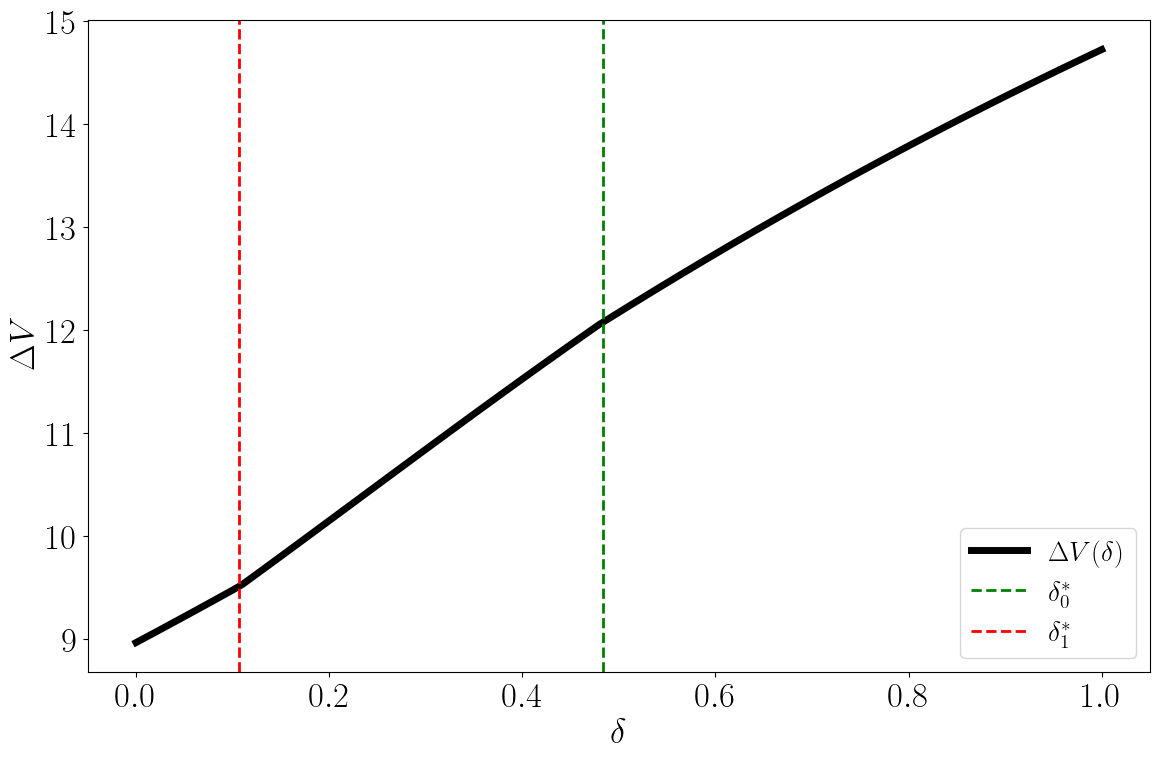

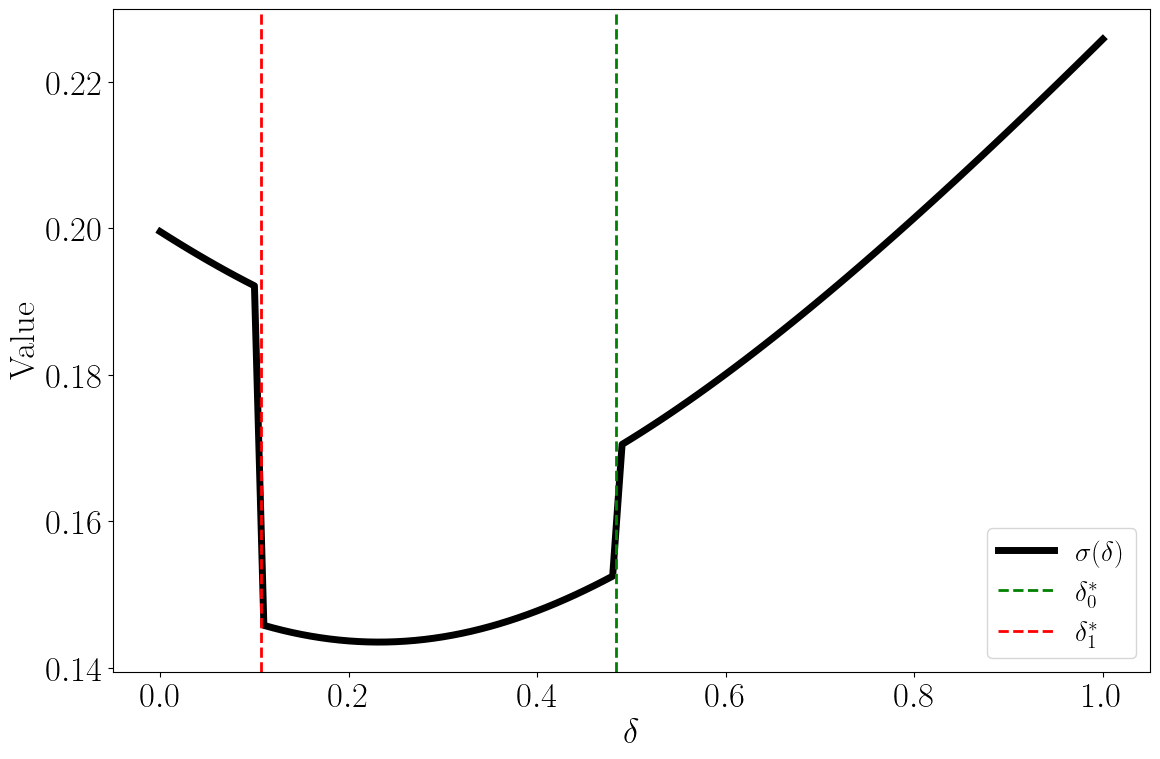

Minimum at 0.23


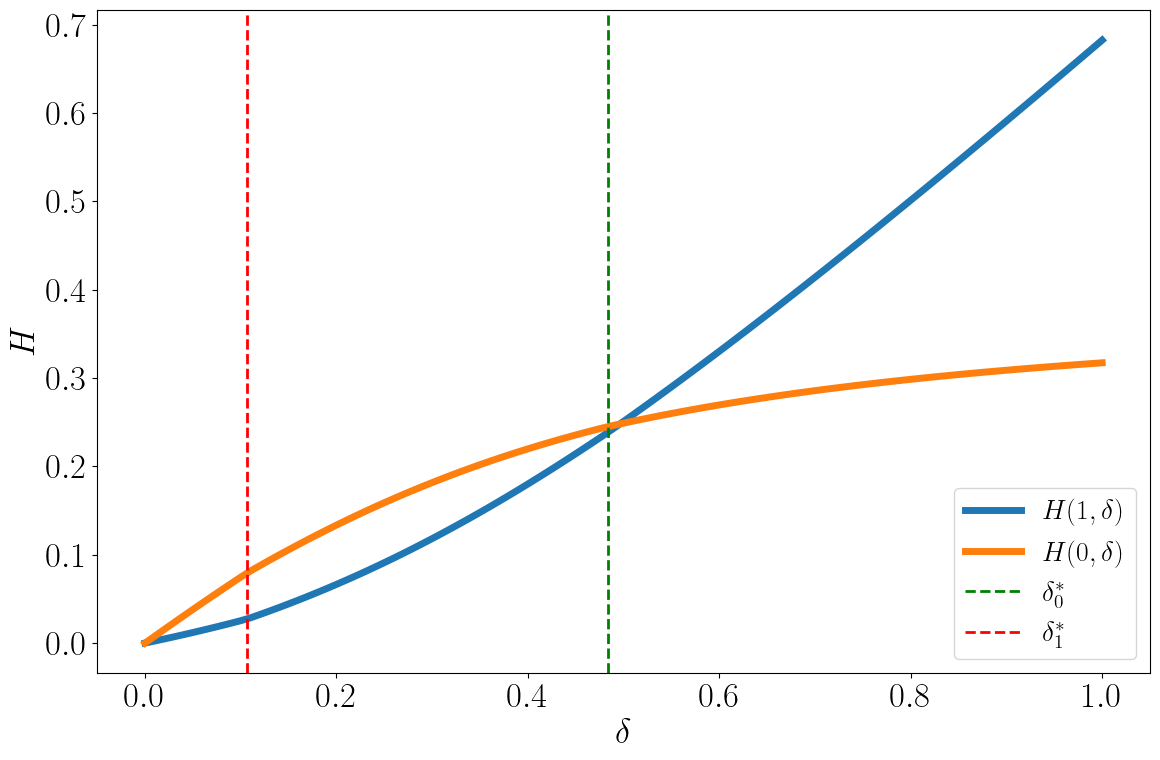

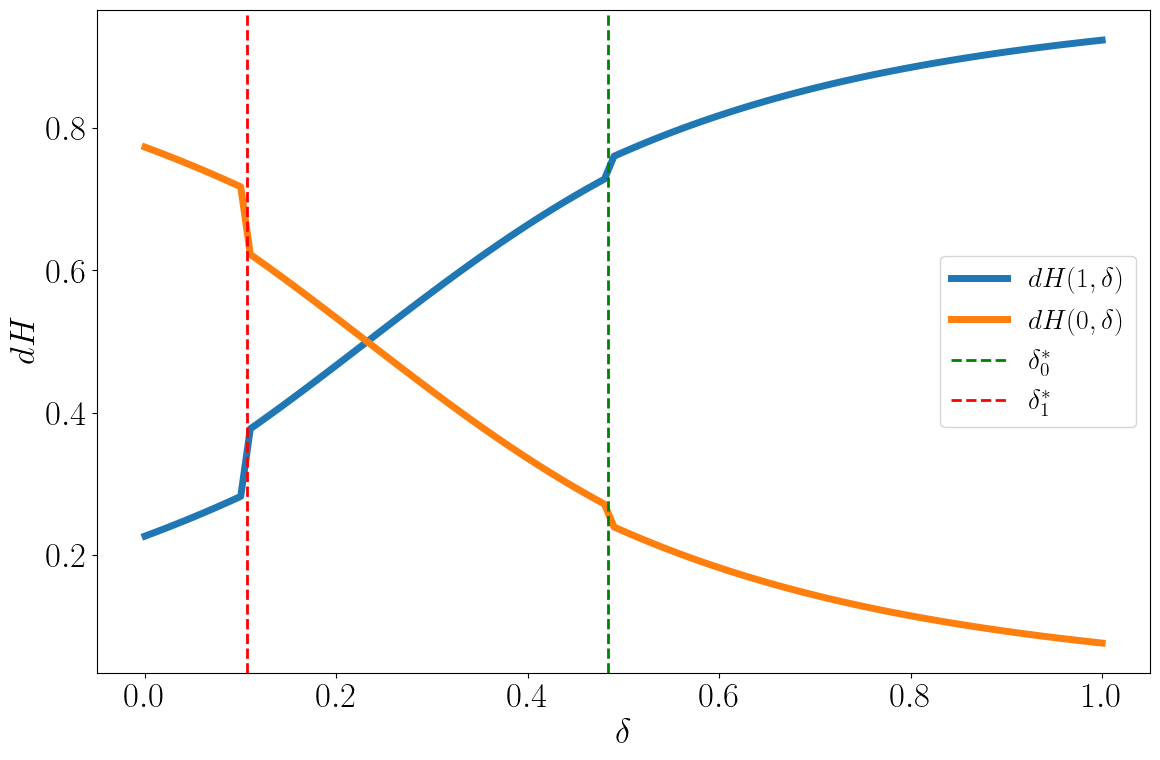

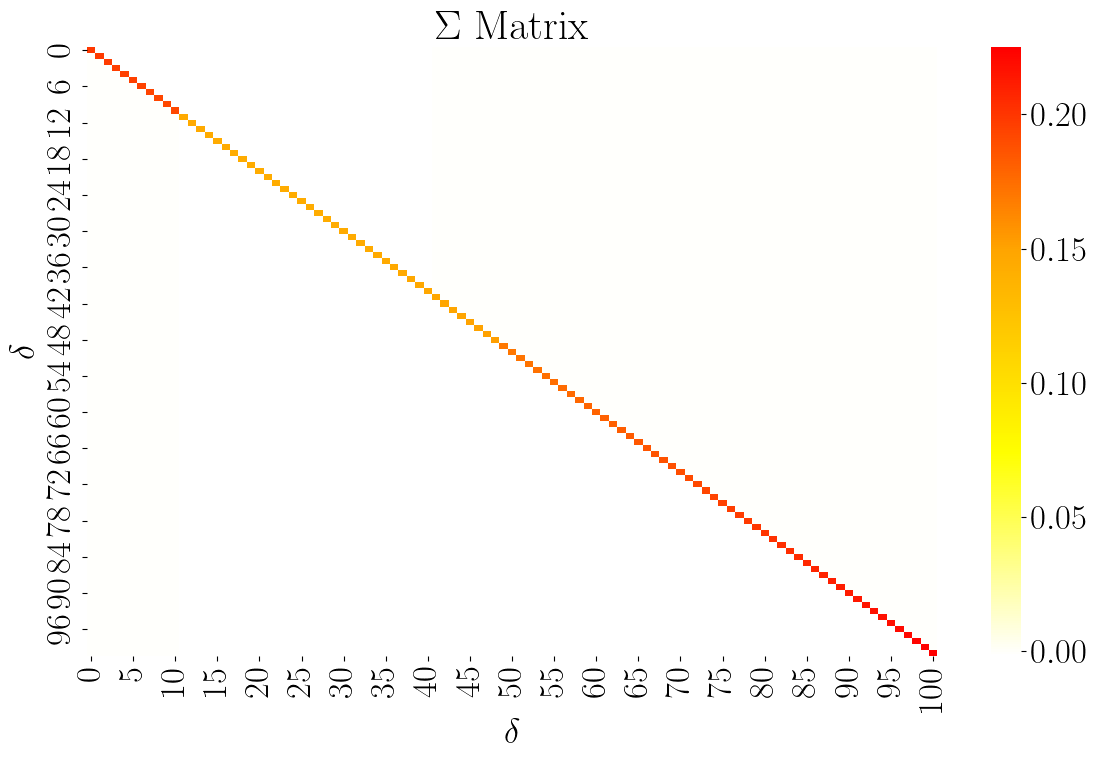

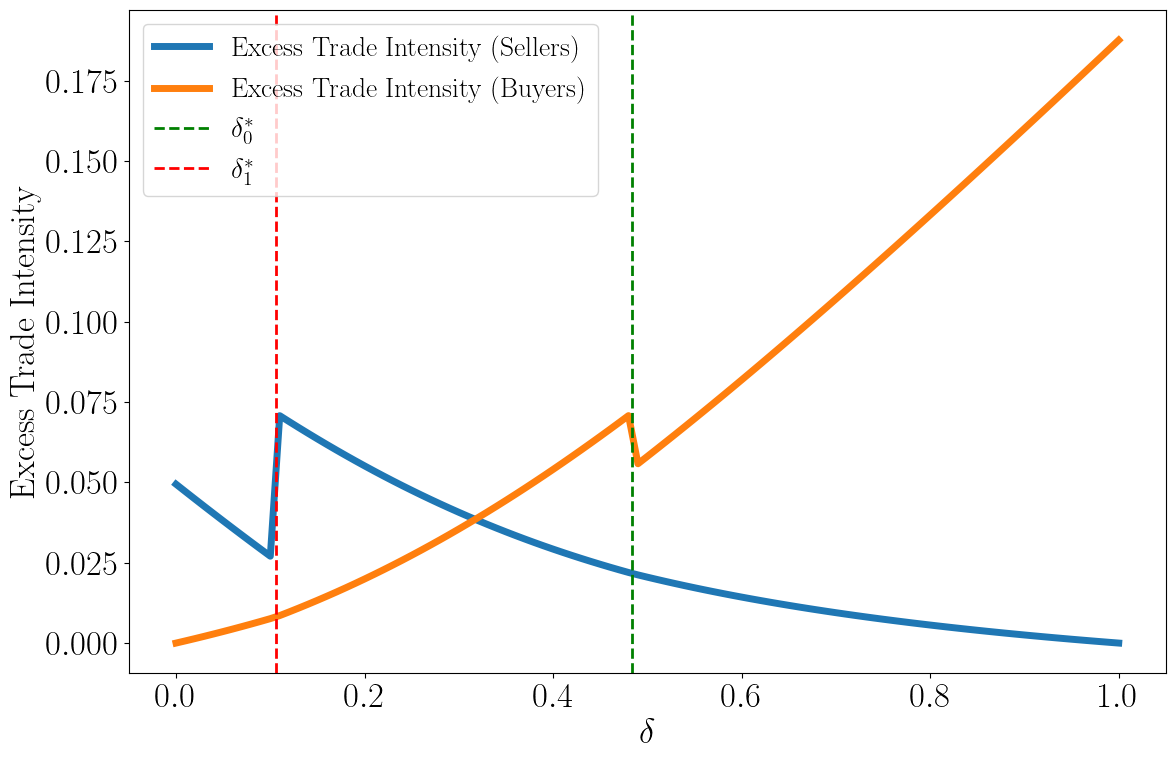

0.483672706 0.106481650304695


In [12]:
# Find optimal delta_0_star and delta_1_star
#optimal_delta_0_star, optimal_delta_1_star = find_optimal_deltas_iterative(r, gamma, s, f, lambda1, rho, delta_grid, np.random.random(), np.random.random())

# Plot the value and dh functions
plot_value_dh_functions(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho, delta_grid)

# Print the optimal values
print(optimal_delta_0_star, optimal_delta_1_star)


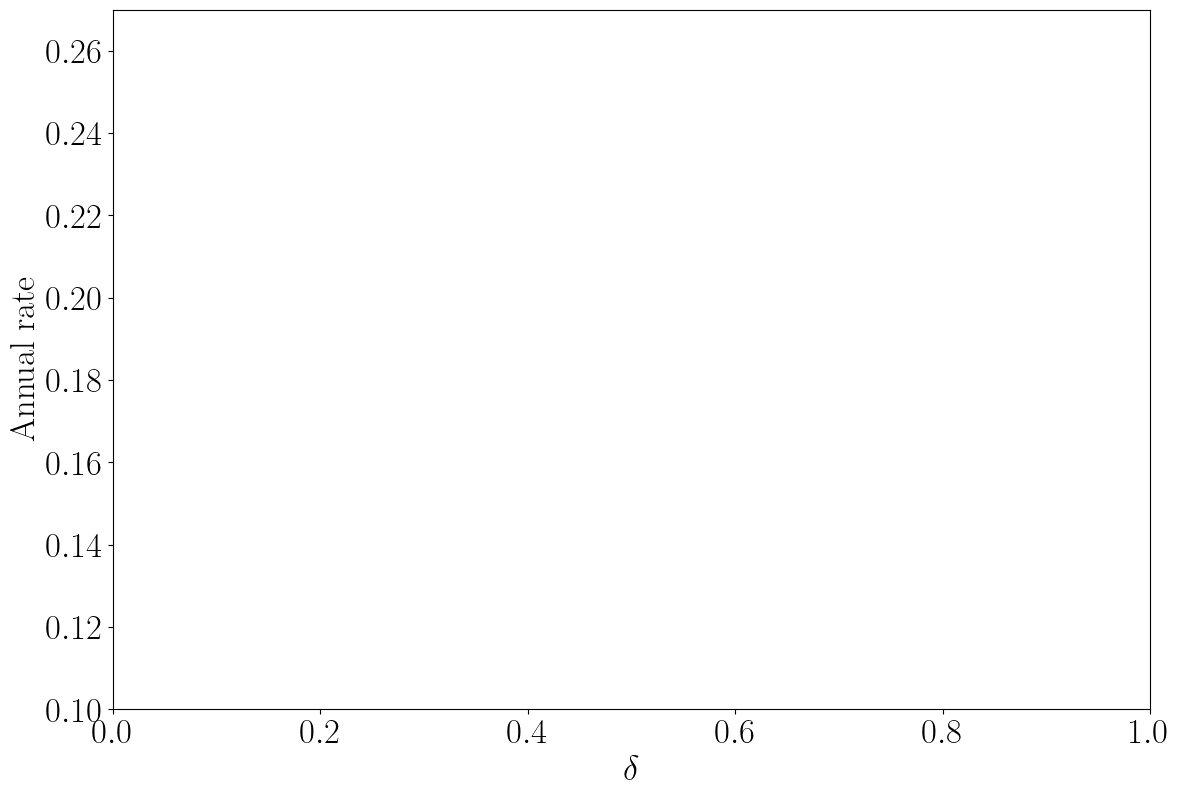

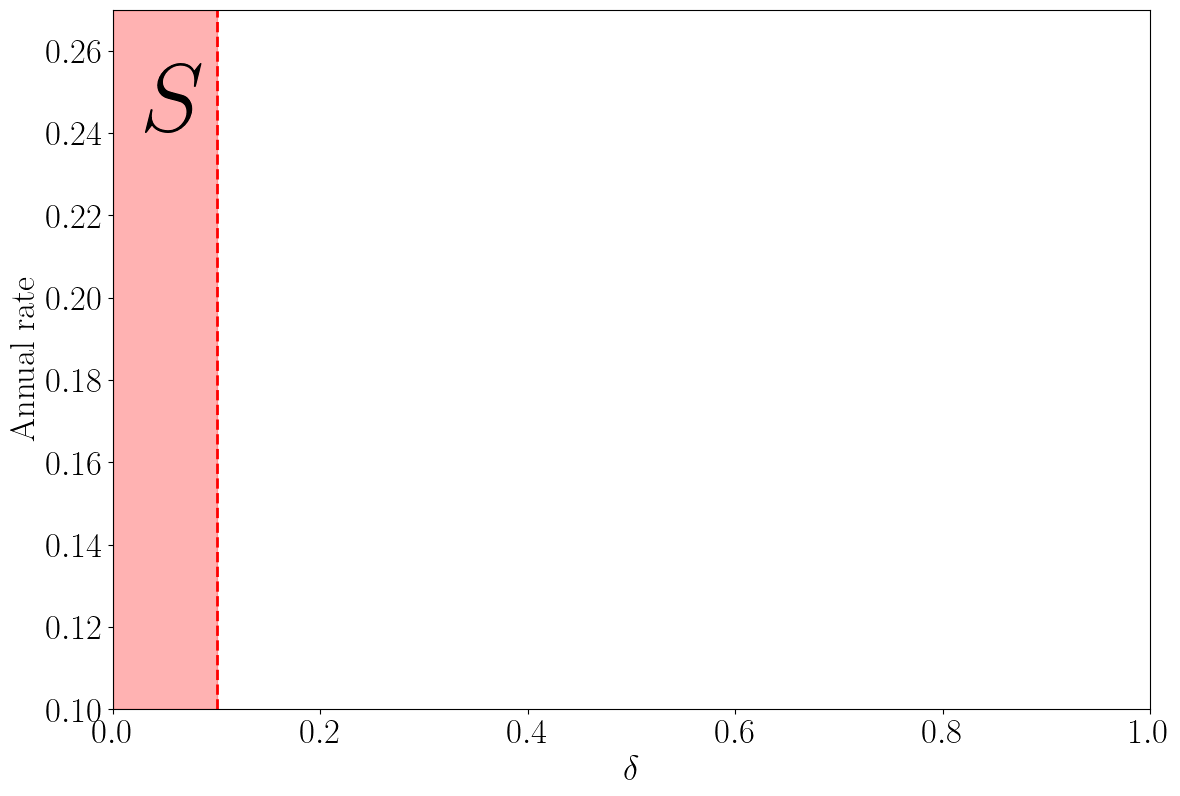

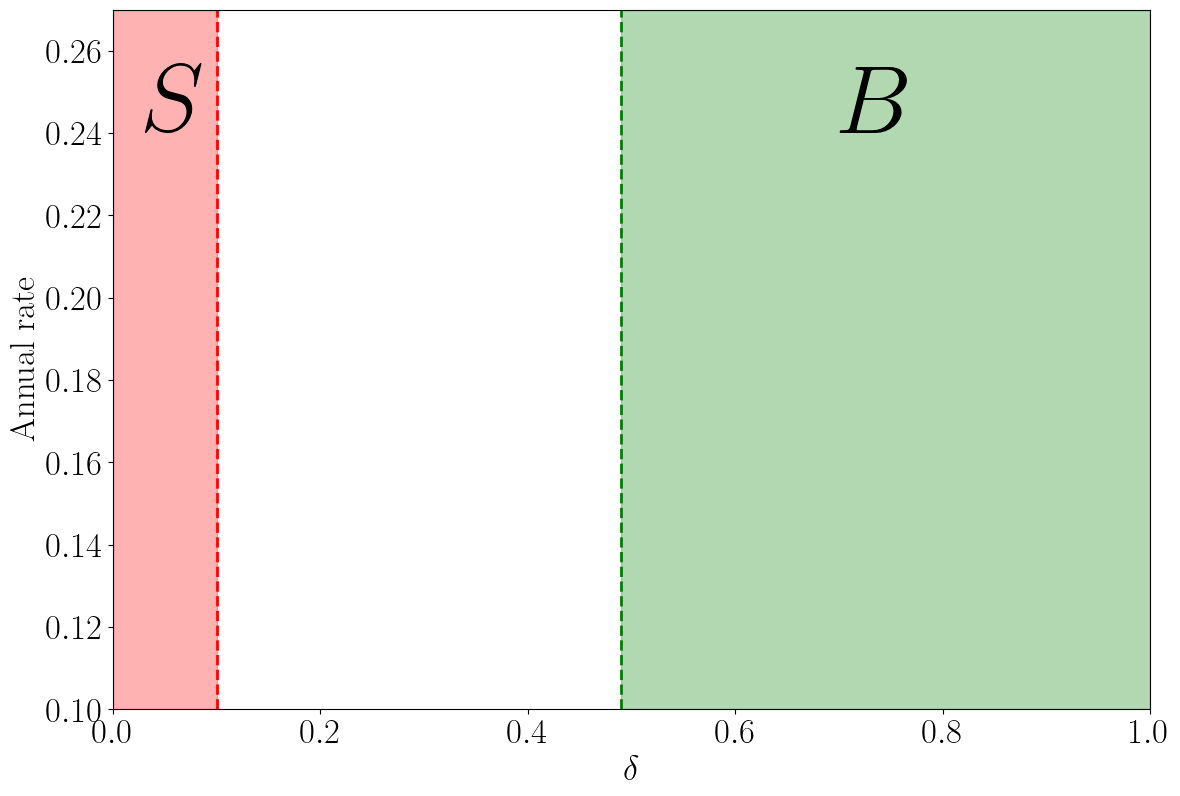

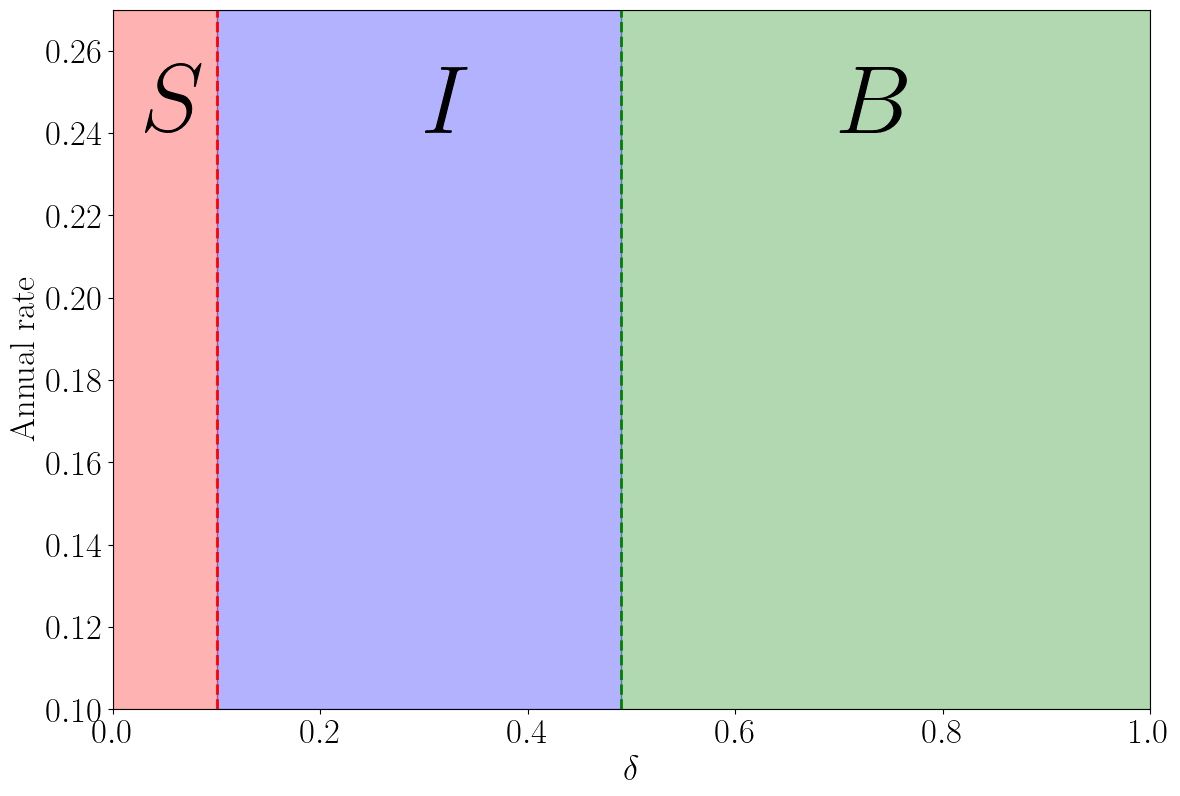

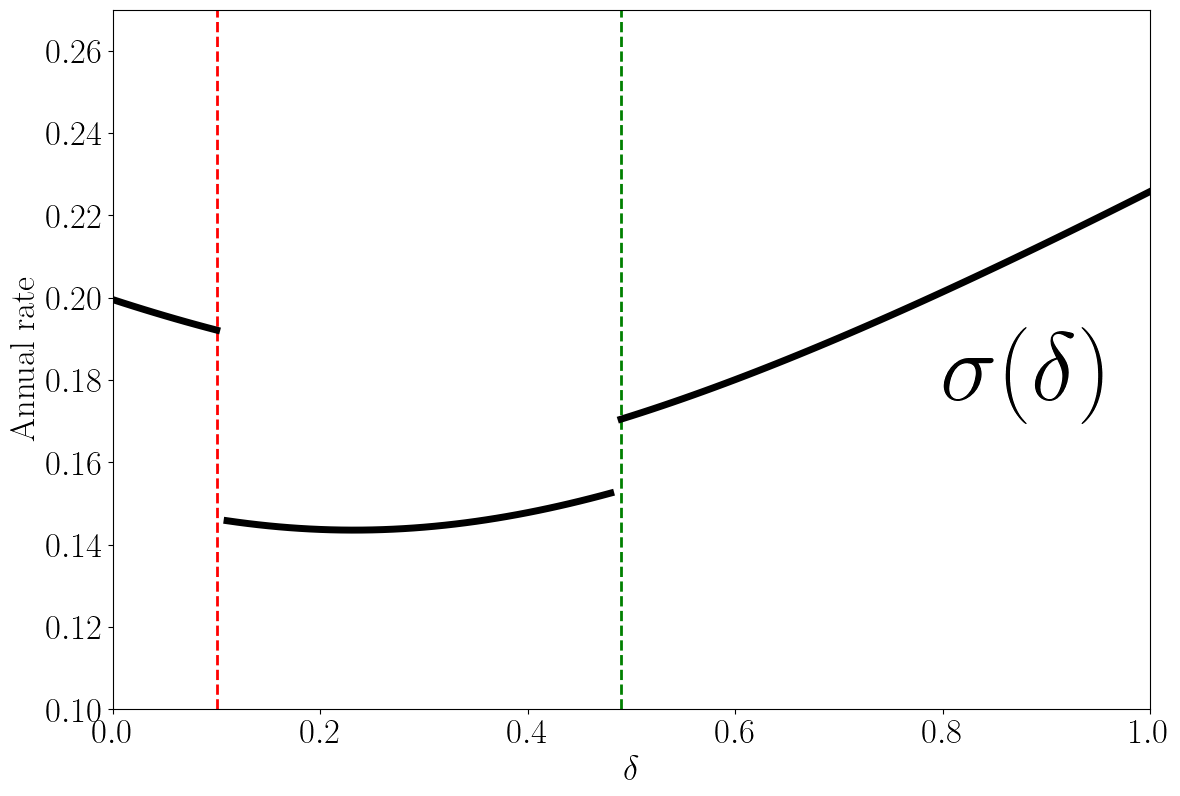

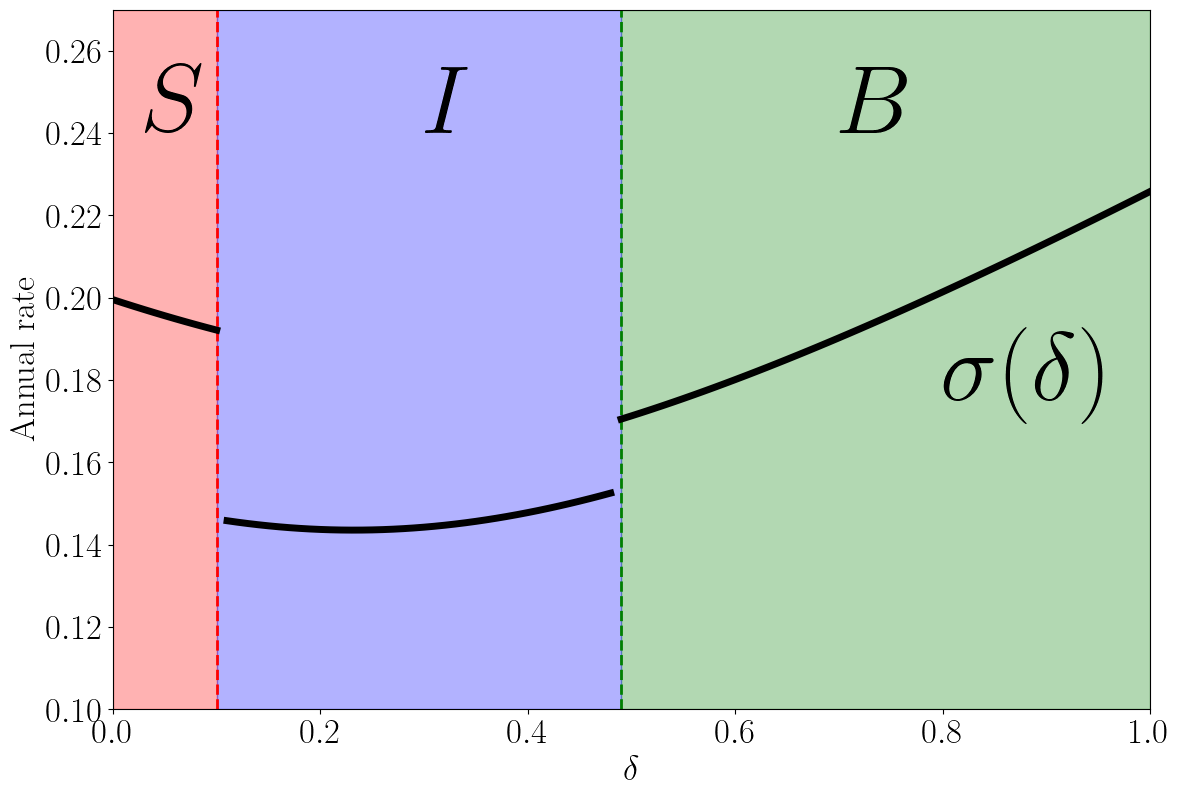

In [13]:
import numpy as np
import matplotlib.pyplot as plt

Sigma_matrix = Sigma(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
optimal_delta_1_star_grid = delta_grid[np.abs(delta_grid - optimal_delta_1_star).argmin()-1]
optimal_delta_0_star_grid = delta_grid[np.abs(delta_grid - optimal_delta_0_star).argmin()+1]
    

# Plot 1: No cutoffs, no colors, just the plot of Delta_V
plt.figure(figsize=(12, 8))
plt.ylim(0.1, 0.27)  # Fix y-axis range
plt.xlim(0.0, 1.0)
plt.tight_layout()
plt.xlabel('$\delta$')
plt.ylabel('Annual rate')
plt.savefig('/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f1a_1.pdf')
plt.show()

# Plot 2: Add delta1 cutoff with transparent bright red color and letter S
plt.figure(figsize=(12, 8))

plt.axvline(x=optimal_delta_1_star_grid, color='red', linestyle='--', linewidth=2)
plt.fill_between(delta_grid, 0.1, 0.27, where=(delta_grid < optimal_delta_1_star), color='red', alpha=0.3)
plt.text(0.03, 0.24, '$S$', fontsize=70, color='black', fontweight='bold')
plt.ylim(0.1, 0.27)
plt.xlim(0.0, 1.0)
plt.tight_layout()
plt.xlabel('$\delta$')
plt.ylabel('Annual rate')
plt.savefig('/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f1a_2.pdf')
plt.show()

# Plot 3: Add delta0 cutoff with transparent bright green color and letter B
plt.figure(figsize=(12, 8))

plt.axvline(x=optimal_delta_1_star_grid, color='red', linestyle='--', linewidth=2)
plt.axvline(x=optimal_delta_0_star_grid, color='green', linestyle='--', linewidth=2)
plt.fill_between(delta_grid, 0.1, 0.27, where=(delta_grid < optimal_delta_1_star), color='red', alpha=0.3)
plt.fill_between(delta_grid, 0.1, 0.27, where=(delta_grid > optimal_delta_0_star), color='green', alpha=0.3)
plt.text(0.03, 0.24, '$S$', fontsize=70, color='black', fontweight='bold')
plt.text(0.7, 0.24, '$B$', fontsize=70, color='black', fontweight='bold')
plt.ylim(0.1, 0.27)
plt.xlim(0.0, 1.0)
plt.tight_layout()
plt.xlabel('$\delta$')
plt.ylabel('Annual rate')
plt.savefig('/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f1a_3.pdf')
plt.show()

# Plot 4: Add blue shading between delta1 and delta0 and letter I
plt.figure(figsize=(12, 8))

plt.axvline(x=optimal_delta_1_star_grid, color='red', linestyle='--', linewidth=2)
plt.axvline(x=optimal_delta_0_star_grid, color='green', linestyle='--', linewidth=2)
plt.fill_between(delta_grid, 0.1, 0.27, where=(delta_grid < optimal_delta_1_star), color='red', alpha=0.3)
plt.fill_between(delta_grid, 0.1, 0.27, where=(delta_grid > optimal_delta_0_star), color='green', alpha=0.3)
plt.fill_between(delta_grid, 0.1, 0.27, where=((delta_grid+0.01 > optimal_delta_1_star) & (delta_grid-0.01< optimal_delta_0_star)), color='blue', alpha=0.3)
plt.text(0.03, 0.24, '$S$', fontsize=70, color='black', fontweight='bold')
plt.text(0.7, 0.24, '$B$', fontsize=70, color='black', fontweight='bold')
plt.text(0.3, 0.24, '$I$', fontsize=70, color='black', fontweight='bold')
plt.ylim(0.1, 0.27)
plt.xlim(0.0, 1.0)
plt.tight_layout()
plt.xlabel('$\delta$')
plt.ylabel('Annual rate')
plt.savefig('/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f1a_4.pdf')
plt.show()

# Plot 5: Show only cutoffs and Sigma curve with label
# Find the indices corresponding to the closest grid points for optimal_delta_1_star and optimal_delta_0_star
index_delta_1_star = np.abs(delta_grid - optimal_delta_1_star_grid).argmin()
index_delta_0_star = np.abs(delta_grid - optimal_delta_0_star_grid).argmin()

# Split the delta_grid and Sigma values into three continuous parts
delta_grid_part1 = delta_grid[:index_delta_1_star+1]  # From 0 to before delta_1_star
delta_grid_part2 = delta_grid[index_delta_1_star+1:index_delta_0_star]  # Between delta_1_star and delta_0_star
delta_grid_part3 = delta_grid[index_delta_0_star:]  # From delta_0_star to 1

sigma_part1 = np.diag(Sigma_matrix)[:index_delta_1_star+1]
sigma_part2 = np.diag(Sigma_matrix)[index_delta_1_star+1:index_delta_0_star]
sigma_part3 = np.diag(Sigma_matrix)[index_delta_0_star:]

plt.figure(figsize=(12, 8))
plt.axvline(x=optimal_delta_1_star_grid, color='red', linestyle='--', linewidth=2)
plt.axvline(x=optimal_delta_0_star_grid, color='green', linestyle='--', linewidth=2)
#plt.plot(delta_grid, np.diag(Sigma_matrix), color='black', label='$\sigma(\delta)$',linewidth=5)
plt.plot(delta_grid_part1, sigma_part1, color='black', linewidth=5)
plt.plot(delta_grid_part2, sigma_part2, color='black', linewidth=5)
plt.plot(delta_grid_part3, sigma_part3, color='black', linewidth=5)


plt.text(0.8, 0.175, '$\sigma(\delta)$', fontsize=70, color='black', fontweight='bold')
plt.ylim(0.1, 0.27)
plt.xlim(0.0, 1.0)
plt.tight_layout()
plt.xlabel('$\delta$')
plt.ylabel('Annual rate')
plt.savefig('/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f1a_5.pdf')
plt.show()


# Plot 6: Everything
plt.figure(figsize=(12, 8))
#plt.plot(delta_grid, np.diag(Sigma_matrix), color='black', label='$\sigma(\delta)$',linewidth=5)


plt.axvline(x=optimal_delta_1_star_grid, color='red', linestyle='--', linewidth=2)
plt.axvline(x=optimal_delta_0_star_grid, color='green', linestyle='--', linewidth=2)
plt.fill_between(delta_grid, 0.1, 0.27, where=(delta_grid < optimal_delta_1_star), color='red', alpha=0.3)
plt.fill_between(delta_grid, 0.1, 0.27, where=(delta_grid > optimal_delta_0_star), color='green', alpha=0.3)
plt.fill_between(delta_grid, 0.1, 0.27, where=((delta_grid+0.01> optimal_delta_1_star) & (delta_grid-0.01 < optimal_delta_0_star)), color='blue', alpha=0.3)
plt.plot(delta_grid_part1, sigma_part1, color='black', linewidth=5)
plt.plot(delta_grid_part2, sigma_part2, color='black', linewidth=5)
plt.plot(delta_grid_part3, sigma_part3, color='black', linewidth=5)
plt.text(0.8, 0.175, '$\sigma(\delta)$', fontsize=70, color='black', fontweight='bold')
plt.text(0.03, 0.24, '$S$', fontsize=70, color='black', fontweight='bold')
plt.text(0.7, 0.24, '$B$', fontsize=70, color='black', fontweight='bold')
plt.text(0.3, 0.24, '$I$', fontsize=70, color='black', fontweight='bold')
plt.ylim(0.1, 0.27)
plt.xlim(0.0, 1.0)
plt.tight_layout()
plt.xlabel('$\delta$')
plt.ylabel('Annual rate')
plt.savefig('/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIG_f1a_6.pdf')
plt.show()


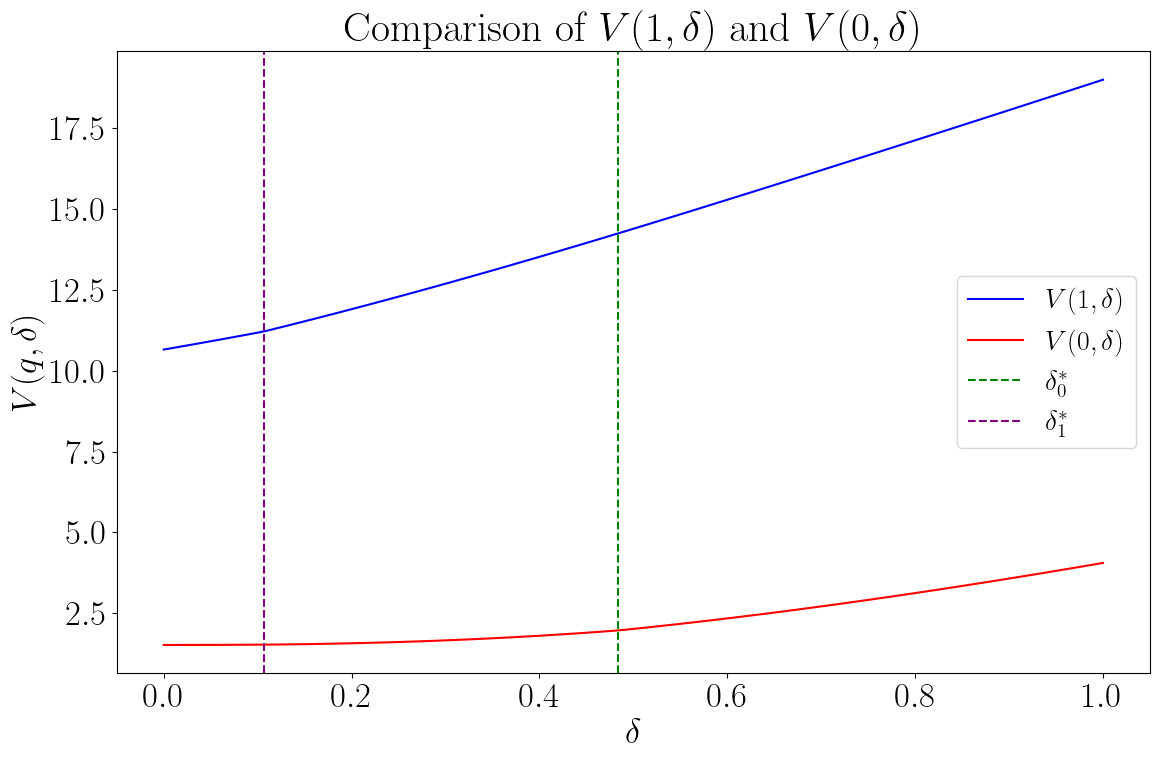

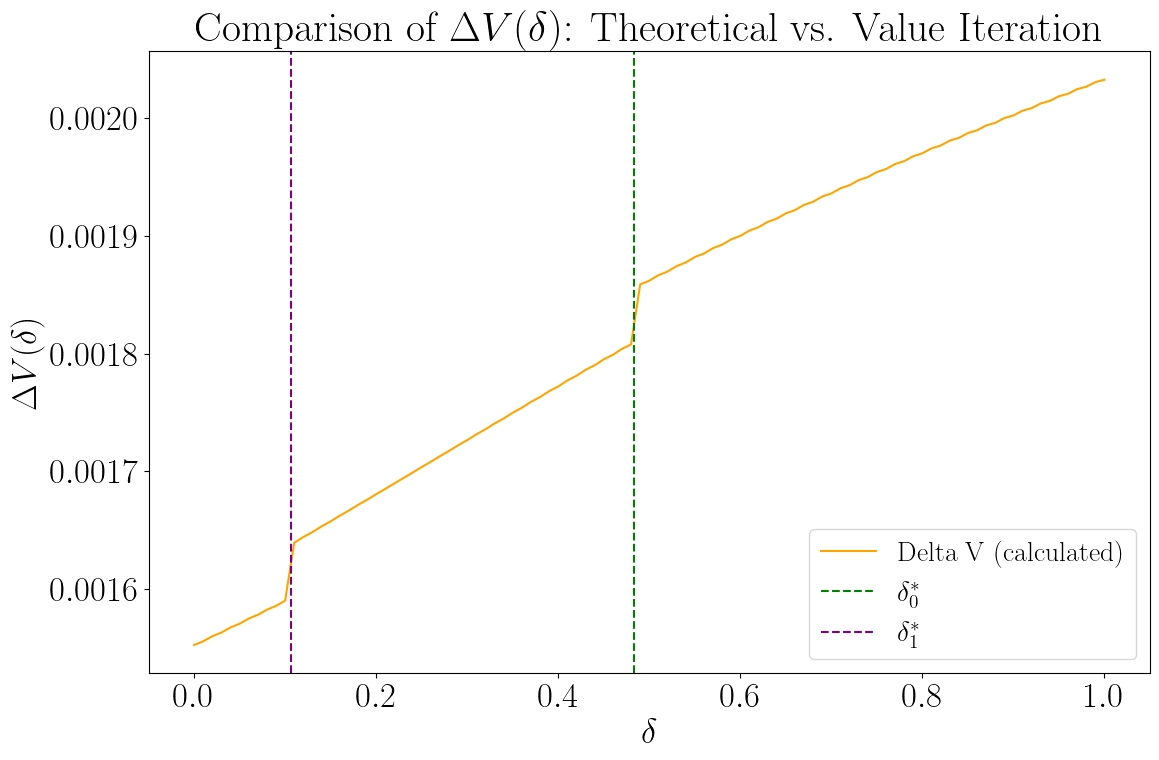

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import simpson
from scipy.interpolate import interp1d

# Define C(1, delta)
def C1(delta, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH0_values, F0_value, delta_1_star, delta_grid):
    integrand_values = (Delta_V_interp(delta_grid) - Delta_V_interp(delta)) * dH0_values
    integrand_values[delta_grid < delta] = 0  # Enforce the integration bounds directly
    integral_term = (rho / 2) * simpson(integrand_values, delta_grid)#np.sum(integrand_values) * (delta_grid[1] - delta_grid[0])
    
    max_term = lambda1 * F0_value * max(0, Delta_V_interp(delta_1_star) - Delta_V_interp(delta))
    
    return delta + integral_term + max_term

# Define C(0, delta)
def C0(delta, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH1_values, F1_value, delta_0_star, delta_grid):
    integrand_values = -(Delta_V_interp(delta_grid) - Delta_V_interp(delta)) * dH1_values
    integrand_values[delta_grid > delta] = 0  # Enforce the integration bounds directly
    integral_term = (rho / 2) *simpson(integrand_values, delta_grid)# np.sum(integrand_values) * (delta_grid[1] - delta_grid[0])
    
    max_term = lambda1 * F1_value * max(0, -(Delta_V_interp(delta_0_star) - Delta_V_interp(delta)))
    
    return integral_term + max_term

# Integrate C(q, delta') over [0, 1]
def integrate_C(C_values, delta_grid):
    delta_width = delta_grid[1] - delta_grid[0]  # Assuming uniform spacing
    return simpson(C_values, delta_grid)#np.sum(C_values) * delta_width


# Compute V(q, delta) and V(0, delta)
def V_q(q, delta, r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star):
    F1_value = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_value = f - F1_value
    # Compute H1_values and H0_values as arrays
    H1_values, H0_values = compute_H_values(delta_grid, delta_0_star, delta_1_star, 
                                            r, gamma, s, f, lambda1, rho)

    # Initialize dH0_values and dH1_values as arrays by using the _gen functions
    dH0_values = dH0_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    dH1_values = dH1_gen( delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    Delta_V, matrix_to_invert = value_iteration(delta_grid, delta_0_star, delta_1_star, 
                                                r, gamma, s, f, lambda1, rho)

    Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")

     
    if q == 1:
        C_q_delta = C1(delta, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH0_values, F0_value, delta_1_star, delta_grid)
        C_values = [C1(d, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH0_values, F0_value, delta_1_star, delta_grid) for d in delta_grid]
    else:
        C_q_delta = C0(delta, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH1_values, F1_value, delta_0_star, delta_grid)
        C_values = [C0(d, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH1_values, F1_value, delta_0_star, delta_grid) for d in delta_grid]
    
    C_integral = integrate_C(C_values, delta_grid)
    
    V_q_delta = (C_q_delta + (gamma / r) * C_integral) / (r + gamma)
    return V_q_delta

# Compute Delta V(delta) = V(1, delta) - V(0, delta)
def calculate_Delta_V(delta_grid, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH0_values, dH1_values, F0_value, F1_value, delta_0_star, delta_1_star):
    V1_values = np.array([V_q(1, delta, r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star) for delta in delta_grid])
    V0_values = np.array([V_q(0, delta, r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star) for delta in delta_grid])
    return V1_values, V0_values, V1_values - V0_values

# Example of usage
def plot_V_q_and_Delta_V(delta_grid, Delta_V, Delta_V_interp, dH0_values, dH1_values, F0_value, F1_value, r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star):
    V1_values, V0_values, Delta_V_theoretical = calculate_Delta_V(delta_grid, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH0_values, dH1_values, F0_value, F1_value, delta_0_star, delta_1_star)

    # Plot V(q, delta) for q = 1 and q = 0
    plt.figure(figsize=(12, 8))
    plt.plot(delta_grid, V1_values, label="$V(1, \delta)$", linestyle='-', color='blue')
    plt.plot(delta_grid, V0_values, label="$V(0, \delta)$", linestyle='-', color='red')
    plt.axvline(x=delta_0_star, color='green', linestyle='--', label='$\delta_0^*$')
    plt.axvline(x=delta_1_star, color='purple', linestyle='--', label='$\delta_1^*$')
    plt.xlabel(r"$\delta$")
    plt.ylabel(r"$V(q, \delta)$")
    plt.title("Comparison of $V(1, \delta)$ and $V(0, \delta)$")
    plt.legend()
    #plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Plotting Delta V(delta) = V(1, delta) - V(0, delta)
    plt.figure(figsize=(12, 8))
    #plt.plot(delta_grid, Delta_V, label="Delta V (solved before)", linestyle='--', color='blue')
    plt.plot(delta_grid, (Delta_V_theoretical-Delta_V)*grid_spacing, label="Delta V (calculated)", linestyle='-', color='orange')
    plt.axvline(x=delta_0_star, color='green', linestyle='--', label='$\delta_0^*$')
    plt.axvline(x=delta_1_star, color='purple', linestyle='--', label='$\delta_1^*$')
    plt.xlabel(r"$\delta$")
    plt.ylabel(r"$\Delta V(\delta)$")
    plt.title("Comparison of $\Delta V(\delta)$: Theoretical vs. Value Iteration")
    plt.legend()
    #plt.grid(True)
    plt.tight_layout()
    plt.show()
F1_value = F1(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
F0_value = f - F1_value
H1_values, H0_values = compute_H_values(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)

    # Initialize dH0_values and dH1_values as arrays by using the _gen functions
dH0_values = dH0_gen( optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
dH1_values = dH1_gen( optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
Delta_V, matrix_to_invert = value_iteration(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)

Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")

plot_V_q_and_Delta_V(delta_grid, Delta_V, Delta_V_interp, dH0_values, dH1_values, F0_value, F1_value, r, gamma, s, f, lambda1, rho, optimal_delta_0_star, optimal_delta_1_star)

In [16]:
V1_values, V0_values, Delta_V_theoretical = calculate_Delta_V(delta_grid, r, gamma, s, f, lambda1, rho, Delta_V_interp, dH0_values, dH1_values, F0_value, F1_value, optimal_delta_0_star, optimal_delta_1_star)




In [17]:
dH1_values = dH1_gen(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
dH0_values = dH0_gen( optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
print(r*simpson(V1_values * dH1_values, delta_grid))
print(r* simpson(V0_values * dH0_values, delta_grid))
print( r*simpson(V1_values * dH1_values, delta_grid)+r* simpson(V0_values * dH0_values, delta_grid))
print( r*np.sum(V1_values * dH1_values)*grid_spacing+r* np.sum(V0_values * dH0_values)*grid_spacing)

0.3765078188380476
0.02145872866942457
0.3979665475074722
0.40177540269051715


In [18]:
delta_0_star_initial, delta_1_star_initial =0.6665367571232512, 0.16746163203442446
f=0.0048366897
s = 0.6884162140
r = 0.0361577940
gamma=0.0867540457
rho =0*0.4133277998
lambda1 =3.9750228339
start_time = time.time()
delta_bar = 1
N_points = 101
delta_grid = np.linspace(0, delta_bar, N_points)


optimal_delta_0_star, optimal_delta_1_star = find_optimal_deltas_iterative(r, gamma, s, f, lambda1, rho, delta_grid, 
                                                                           delta_0_star_initial, delta_1_star_initial,
                                                                              tolerance=1e-3)
print("Optimal delta_0_star:", optimal_delta_0_star)
print("Optimal delta_1_star:", optimal_delta_1_star)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total time for operations: {elapsed_time:.2f} seconds")


Optimal delta_0_star: 0.6665367571232512
Optimal delta_1_star: 0.16746163203442446
Total time for operations: 2.37 seconds


In [19]:
import numpy as np
from scipy.integrate import quadrature
# Convert optimal_delta_0_star and optimal_delta_1_star to indices
optimal_delta_0_index = np.searchsorted(delta_grid, optimal_delta_0_star, side='left')
optimal_delta_1_index = np.searchsorted(delta_grid, optimal_delta_1_star, side='right')



def V1_update(V1_n, delta_grid, optimal_delta_0_index, optimal_delta_1_index, r, gamma, s, f, lambda1, rho, Delta_V, dH0_values):
    N = len(delta_grid)
    V1_next = np.zeros(N)
    grid_spacing = delta_grid[1] - delta_grid[0]  # Spacing of the delta grid
    F1_value = F1(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_value = f - F1_value

    # Iterate over the delta grid to update V1
    for i, delta in enumerate(delta_grid):
        # First term: delta / (r + gamma)
        V1_next[i] = delta / (r + gamma)

        # Second term: Summation approximation of the integral (normalize with grid spacing)
        sum_integral = simps(V1_n, delta_grid)  # Using Simpson's rule
        V1_next[i] += (gamma / (r + gamma)) * sum_integral

        # Third term: Apply the indicator function and F(0) only if delta < delta_1_star
        if delta < delta_grid[optimal_delta_1_index]:
            V1_next[i] += (lambda1 / (r + gamma)) * F0_value * (Delta_V[optimal_delta_1_index] - Delta_V[i])

        # Fourth term: Numerical approximation of the integral involving dH0 using Simpson's rule
        
            # Correct the integral form: rho/(r+gamma) * sum_j=i+1 (Delta_V(delta_j) - Delta_V(delta_i)) * dH0(delta_j)
        integral_term = 0
        for j in range(i + 1, N):
            integral_term += (Delta_V[j] - Delta_V[i]) * dH0_values[j]*grid_spacing 
        V1_next[i] += 0.5*(rho / (r + gamma)) * integral_term

    return V1_next

def V0_update(V0_n, delta_grid, optimal_delta_0_index, optimal_delta_1_index, r, gamma, s, f, lambda1, rho, Delta_V, dH1_values):
    N = len(delta_grid)
    V0_next = np.zeros(N)
    grid_spacing = delta_grid[1] - delta_grid[0]

    F1_value = F1(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_value = f - F1_value
    
    # Iterate over the delta grid to update V0
    for i, delta in enumerate(delta_grid):
        # First term: Summation approximation (normalize with grid spacing)
        sum_integral = simps(V0_n, delta_grid)  # Using Simpson's rule
        V0_next[i] = (gamma / (r + gamma)) * sum_integral

        # Second term: Apply the indicator function and F(1) only if delta > delta_0_star
        if delta > delta_grid[optimal_delta_0_index]:
            V0_next[i] += (lambda1 / (r + gamma)) * F1_value * (Delta_V[i] - Delta_V[optimal_delta_0_index])

        # Third term: Numerical approximation of the integral involving dH1 using Simpson's rule
        
        integral_term = 0
        for j in range(0, i):
            integral_term += (Delta_V[j] - Delta_V[i]) * dH1_values[j]*grid_spacing
        V0_next[i] += -0.5*(rho / (r + gamma)) * integral_term

    return V0_next





# Value function iteration
def value_function_iteration_new(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, 
                                 s, f, lambda1, rho, max_iterations=3000, tolerance=1e-20):
    N = len(delta_grid)
    
    # Convert optimal_delta_*_star to indices
    optimal_delta_0_index = np.argmin(np.abs(delta_grid - optimal_delta_0_star))
    optimal_delta_1_index = np.argmin(np.abs(delta_grid - optimal_delta_1_star))
    
    
    
    # Use the value_iteration to get Delta_V and dH values
    Delta_V, _ = value_iteration(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
    dH0_values = dH0_gen(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
    dH1_values = dH1_gen(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
    # Initial guesses for V^n(1, delta) and V^n(0, delta)
    V1_n = delta_grid / (r + gamma)
    V0_n = delta_grid / (r + gamma)
    for iteration in range(max_iterations):
        # Update V1 and V0 using the update functions
        V1_next = V1_update(V1_n, delta_grid, optimal_delta_0_index, optimal_delta_1_index, r, gamma, s, f, lambda1, rho, Delta_V, dH0_values)
        V0_next = V0_update(V0_n, delta_grid, optimal_delta_0_index, optimal_delta_1_index, r, gamma, s, f, lambda1, rho, Delta_V, dH1_values)

        # Check for convergence
        diff_V1 = np.max(np.abs(V1_next - V1_n))
        diff_V0 = np.max(np.abs(V0_next - V0_n))
        if diff_V1 < tolerance and diff_V0 < tolerance:
            print(f"Converged in {iteration} iterations")
            break

        # Update V1_n and V0_n for the next iteration
        V1_n = V1_next
        V0_n = V0_next

    return V1_next, V0_next

import matplotlib.pyplot as plt

def plot_difference(delta_grid, Delta_V, V1_next, V0_next):
    difference = Delta_V - V1_next + V0_next

    plt.figure(figsize=(12, 8))
    plt.plot(delta_grid, difference, label="Difference ($\Delta V(\delta) - (V(1,\delta) - V(0,\delta))$", color="orange")
    #plt.plot(delta_grid, Delta_V, label="($\Delta V(\delta) )$", color="red")
    #plt.plot(delta_grid, V1_next - V0_next, label="Difference ($ (V(1,\delta) - V(0,\delta))$", color="blue")
    
    plt.xlabel('$\delta$')
    plt.ylabel('Difference')
    #plt.title('Difference between $\Delta V(\delta)$ and $V(1,\delta) - V(0,\delta)$')
    plt.legend()
    plt.grid(True)
    plt.show()

ImportError: cannot import name 'quadrature' from 'scipy.integrate' (/Users/user/.venvs/main/lib/python3.12/site-packages/scipy/integrate/__init__.py)

In [ ]:
# Run the value function iteration
V1_final, V0_final = value_function_iteration_new(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, 
                                 s, f, lambda1, rho, max_iterations=300, tolerance=1e-10)
  

# Get Delta_V from value_iteration for comparison
Delta_V, matrix_to_invert = value_iteration(delta_grid, delta_0_star_initial, delta_1_star_initial, r, gamma, s, f, lambda1, rho)

# Plot the difference between Delta_V and (V1 - V0)
plot_difference(delta_grid, Delta_V, V1_final, V0_final)
print("Shapes of Delta_V, V1_final, V0_final:", Delta_V.shape, V1_final.shape, V0_final.shape)
# Calculate absolute error
error = np.max(np.abs(Delta_V - (V1_final - V0_final)))
print("Absolute error:", error)
print(Delta_V - V1_final + V0_final)

In [20]:
delta_0_star_initial, delta_1_star_initial =0.6669796057594066, 0.16707332172447217
f=0.0048366897
s = 0.6884162140
r = 0.0361577940
gamma=0.0867540457
rho =0*0.4133277998
lambda1 =3.9750228339
start_time = time.time()


optimal_delta_0_star, optimal_delta_1_star = find_optimal_deltas_iterative(r, gamma, s, f, lambda1, rho, delta_grid, 
                                                                           delta_0_star_initial, delta_1_star_initial,
                                                                              tolerance=1e-4)
print("Optimal delta_0_star:", optimal_delta_0_star)
print("Optimal delta_1_star:", optimal_delta_1_star)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Total time for operations: {elapsed_time:.2f} seconds")


Optimal delta_0_star: 0.6669796057594066
Optimal delta_1_star: 0.16707332172447217
Total time for operations: 2.03 seconds


In [22]:
kappa_hh_over2, kappa_flipper_under2=trade_volume_2years(r, gamma, s, f, lambda1, rho, dH0_values, dH1_values, delta_0_star, delta_1_star)

NameError: name 'delta_0_star' is not defined

In [27]:
# Trade of households over 2 years
def trade_hh_over2(r, gamma, s, f, lambda1, rho, dH0_values, dH1_values):
    # Indicator matrix for delta_prime >= delta
    Indicator_matrix = np.less_equal.outer(delta_grid, delta_grid).astype(float)
    
    # Compute the exp term over two years with grid spacing included
    exp_term = np.exp(-2 * rho * np.cumsum(dH1_values, axis=0) * grid_spacing)
    
    # Compute kappa1 over 2 years
    kappa_hh_over2 = rho * np.sum(dH1_values @ (Indicator_matrix * exp_term) @ dH0_values.T) * grid_spacing**2
    return kappa_hh_over2

# Trade of flippers under 2 years
def trade_flipper_under2(r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star):
    F0_value = F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F1_value=f-F0_value
    # Integral of dH1 up to delta_1_star
    #integral_dH1_delta1 = np.sum(dH1_values[delta_grid <= delta_1_star]) * grid_spacing
    #integral_dH0_delta0 = np.sum(dH0_values[delta_0_star  <= delta_grid]) * grid_spacing
    integral_dH1_delta1= H1(delta_1_star, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)
    integral_dH0_delta0= H0(1.0, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)-H0(delta_0_star, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)

    # Compute the exponential term
    exp_term_flippers1 = 1 - np.exp(-2 * lambda1 * integral_dH1_delta1)
    exp_term_flippers0 = 1 - np.exp(-2 * lambda1 * integral_dH0_delta0)
    # Compute kappa2 under 2 years
    kappa_flipper_under2 = lambda1 * (F0_value * integral_dH1_delta1 *exp_term_flippers0+F1_value * integral_dH0_delta0* exp_term_flippers1)
    return kappa_flipper_under2

# Example of how to compute total trade volume under and over 2 years
def trade_volume_2years(r, gamma, s, f, lambda1, rho, dH0_values, dH1_values, delta_0_star, delta_1_star):
    kappa_hh_over2 = trade_hh_over2(r, gamma, s, f, lambda1, rho, dH0_values, dH1_values)
    kappa_flipper_under2 = trade_flipper_under2(r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star)
    
    return kappa_hh_over2, kappa_flipper_under2


In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Calculate trade volume among households (kappa1)
def trade_hh(r, gamma, s, f, lambda1, rho, dH0_values, dH1_values):
    # Indicator matrix for delta_prime >= delta
    Indicator_matrix = np.less_equal.outer(delta_grid, delta_grid).astype(float)
    
    # Compute kappa1 with grid spacing included
    kappa_13 = rho * np.sum(dH1_values @ Indicator_matrix @ dH0_values.T) * grid_spacing**2
    return kappa_13

# Calculate trade volume involving flippers (kappa2)
def trade_flipper(r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star):
    F0_value = F0(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    #H1_delta1 = dH1(delta_1_star, delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    H1_delta1 = H1(delta_1_star, delta_0_star, delta_1_star, F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho), r, gamma, s, f, lambda1, rho)

    # Compute kappa2
    kappa_23 = 2*lambda1 * F0_value * H1_delta1
    return kappa_23

# Compute total trade volume kappa
def trade_volume(r, gamma, s, f, lambda1, rho, dH0_values, dH1_values, delta_0_star, delta_1_star):
    kappa13 = trade_hh(r, gamma, s, f, lambda1, rho, dH0_values, dH1_values)
    kappa23 = trade_flipper(r, gamma, s, f, lambda1, rho, delta_0_star, delta_1_star)
    kappa3 = kappa13 + kappa23
    return kappa3, kappa13, kappa23

Trade Volume kappa: 0.0018926101110300685, kappa1 (households): 0.0, kappa2 (flippers): 0.0018926101110300685
Fraction of flipper trade kappa2/kappa: 1.0
P1,P0, P1-P0 15.124924062043764 11.05937605838048 4.0655480036632845
Computed Mean of P: 13.124534083722567
Computed Variance of P: 4.151319630986465
Computed Skewness of P: -1.3824517333629396e-15
P50/P10: 1.0056866459992997


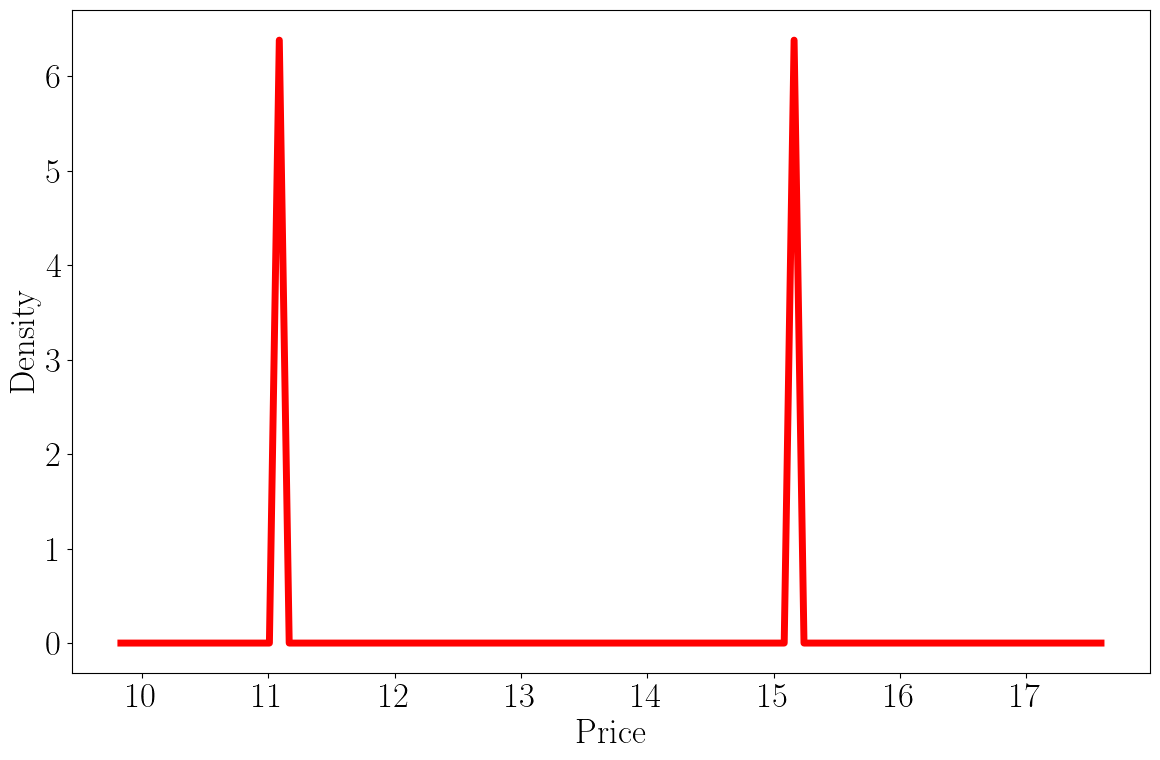

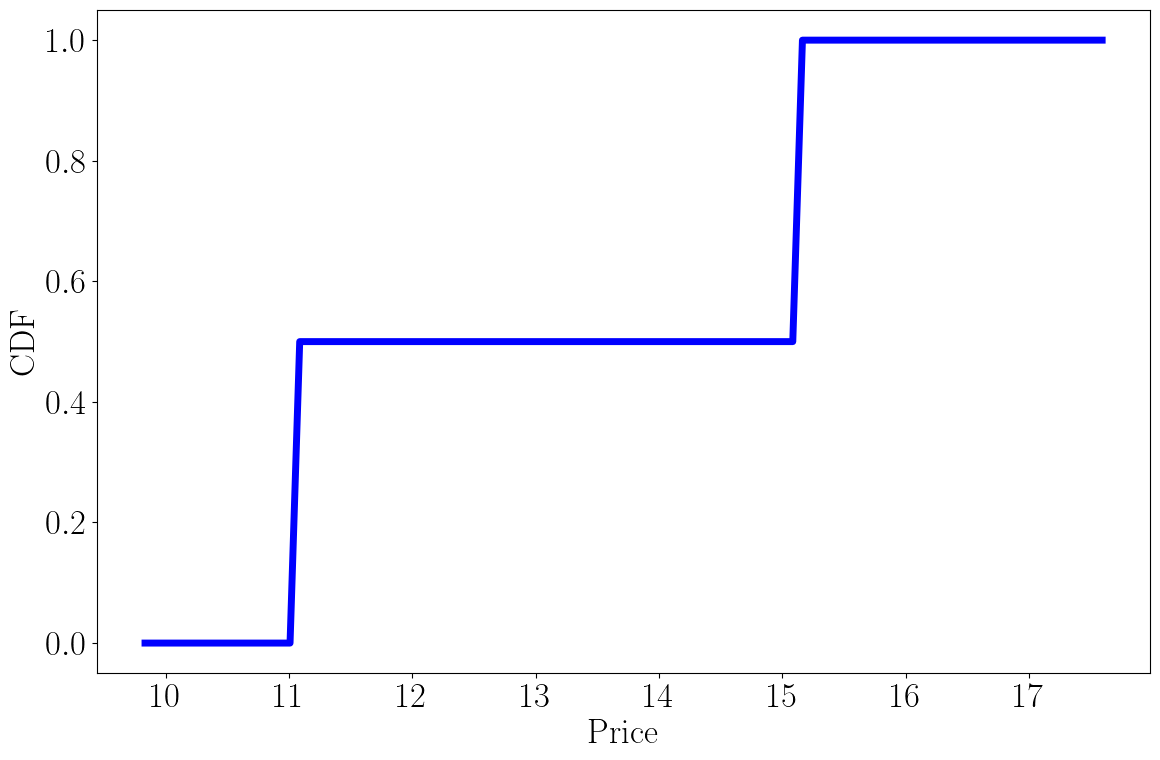

In [28]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Function to compute P_mean and P_variance
def compute_P_mean_variance(p_values, F_P):
    # Compute the PDF using finite differences
    delta_p = p_values[1] - p_values[0]
    f_P = np.diff(F_P) / np.diff(p_values)
    
    # Normalize the PDF
    f_P_sum = np.sum(f_P) * delta_p
    f_P = f_P / f_P_sum
    p_values_mid = (p_values[:-1] + p_values[1:]) / 2  # Midpoints for plotting PDF

    # Compute the mean and variance using the PDF
    P_mean = np.sum(p_values_mid * f_P) * delta_p
    P_variance = np.sum((p_values_mid - P_mean) ** 2 * f_P) * delta_p

    return P_mean, P_variance


# Function to compute skewness
def compute_skewness(p_values_mid, f_P, P_mean, P_variance):
    # Skewness is the third standardized moment
    delta_p = p_values_mid[1] - p_values_mid[0]
    P_skewness = np.sum(((p_values_mid - P_mean) ** 3) * f_P) * delta_p / (P_variance ** 1.5)
    return P_skewness

# Function to calculate percentiles
def compute_percentile(cdf_values, p_values, target):
    if target <= cdf_values[0]:
        return p_values[0]
    elif target >= cdf_values[-1]:
        return p_values[-1]
    else:
        return interp1d(cdf_values, p_values, fill_value="extrapolate")(target)

# Calculate price distribution (CDF)
def price_distribution(r, gamma, s, f, lambda1, rho, Delta_V_interp, 
                       dH0_values, dH1_values, kappa1, kappa2, 
                       delta_0_star, delta_1_star):

    # Find the indices on delta_grid corresponding to delta_0_star and delta_1_star
    #delta_0_idx = np.searchsorted(delta_grid, delta_0_star)
    #delta_0_idx = int(delta_0_idx)
    #delta_1_idx = np.searchsorted(delta_grid, delta_1_star)
    #delta_1_idx = int(np.floor(delta_1_idx))  # Ensure it is an integer index

    F1_val = F1(delta_0_star, delta_1_star, r, gamma, s, f, lambda1, rho)
    F0_val = f - F1_val
    # Define price grid
    p_values = np.linspace(np.min(Delta_V_interp(delta_grid)), np.max(Delta_V_interp(delta_grid)), len(delta_grid))
    
    # Create price matrix P(delta, delta_prime)
    P_matrix = np.array([[P(delta, delta_prime, Delta_V_interp) for delta_prime in delta_grid] for delta in delta_grid])
    
    # Initialize CDF array
    F_P = np.zeros(len(p_values))
    
    # Calculate the CDF
    for k, p in enumerate(p_values):
        # Indicator matrix for P(delta, delta_prime) <= p
        I_p = (P_matrix <= p).astype(float)
        
        # Apply both indicators 1_{\delta' > \delta} and 1_{P(\delta, \delta') <= p}
        I_delta_prime_greater_delta = np.triu(np.ones_like(P_matrix), 1)  # Upper triangular matrix to enforce \delta' > \delta
        I_combined = I_p  * I_delta_prime_greater_delta
        
        # Double integral for the CDF (first term)
        integral_double = grid_spacing**2 * np.sum(dH1_values @ I_combined @ dH0_values.T)
        
        # Marginal contributions from P0 and P1 (second and third terms)
        if P0(Delta_V_interp, delta_1_star) <= p:
            integral_P0 = kappa2/2
            #H1(optimal_delta_1_star, optimal_delta_0_star, optimal_delta_1_star, F1_val, r,gamma, s, f, lambda1, rho) * F0_val
      
        else:
            integral_P0 = 0
        
        if P1(Delta_V_interp, delta_0_star) <= p:
            integral_P1 = kappa2/2
            #H0(optimal_delta_0_star, optimal_delta_0_star, optimal_delta_1_star, F1_val, r, gamma, s, f, lambda1, rho) * F1_val
       
        else:
            integral_P1 = 0
        
        # Combine into CDF value, scaled by appropriate factors
        #F_P[k] = (integral_double *rho / kappa1) + (integral_P0 * lambda1*F0_val*2/kappa2) + (integral_P1 * lambda1*F1_val*2/kappa2)
        #F_P[k] = integral_double*rho/(kappa1 +kappa2)  + integral_P0*kappa2/(2*(kappa1 +kappa2))  + integral_P1 *kappa2/(2*(kappa1 +kappa2)) 
        F_P[k] = (integral_double*rho+integral_P0+ integral_P1 )/(kappa1 +kappa2) 
    
    delta_p = p_values[1] - p_values[0]
    
    
    # Normalize the CDF
    F_P_sum = np.sum(F_P) * delta_p
    F_P = F_P / F_P_sum
    return p_values, F_P

# Plot price distribution
# Plot price distribution
def plot_price_distribution(p_values, F_P):
        # Compute the PDF using finite differences
    delta_p = p_values[1] - p_values[0]
    f_P = np.diff(F_P) / np.diff(p_values)
    
    # Normalize the PDF
    f_P_sum = np.sum(f_P) * delta_p
    f_P = f_P / f_P_sum
    p_values_mid = (p_values[:-1] + p_values[1:]) / 2  # Midpoints for plotting PDF

    # Compute the mean, variance, and skewness using the compute_P_mean_variance function
    P_mean, P_variance = compute_P_mean_variance(p_values, F_P)
    P_skewness = compute_skewness(p_values_mid, f_P, P_mean, P_variance)

    # Normalize the CDF
    cdf_values = np.cumsum(f_P) * (p_values_mid[1] - p_values_mid[0])
    
    # Calculate P80/P20 ratio
    p50 = compute_percentile(cdf_values, p_values_mid, 0.50)
    p10 = compute_percentile(cdf_values, p_values_mid, 0.10)
    P50_P10 = p50 / p10
    print(f"P50/P10: {P50_P10}")

    # Define output paths
    output_path_pdf = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/Price_pdf.pdf"
    output_path_cdf = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/Price_cdf.pdf"

    # Plot the PDF of prices
    plt.figure(figsize=(12, 8))
    plt.plot(p_values_mid, f_P, color='red', linewidth=5)
    plt.xlabel('Price')
    plt.ylabel('Density')
    #plt.title('PDF of Price Distribution')
    #plt.grid(True)
    plt.tight_layout()
    plt.savefig(output_path_pdf)
    plt.show()

    # Plot the CDF of prices
    plt.figure(figsize=(12, 8))
    plt.plot(p_values_mid, cdf_values, color='blue', linewidth=5)
    plt.xlabel('Price')
    plt.ylabel('CDF')
    #plt.title('CDF of Price Distribution')
    #plt.grid(True)
    plt.tight_layout()
    plt.savefig(output_path_cdf)
    plt.show()


# Example usage with the updated functions
# Assuming other necessary variables are already defined: delta_grid, optimal_delta_0_star, optimal_delta_1_star, etc.

# Running value iteration to get Delta_V
Delta_V, _ = value_iteration(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)

# Interpolating Delta_V
Delta_V_interp = interp1d(delta_grid, Delta_V, kind='linear', fill_value="extrapolate")

# Calculate dH0 and dH1 values
H_values = compute_H_values(delta_grid, optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
dH0_values = dH0_gen(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)
dH1_values = dH1_gen(optimal_delta_0_star, optimal_delta_1_star, r, gamma, s, f, lambda1, rho)

# Compute trade volumes
grid_spacing = delta_grid[1] - delta_grid[0]
kappa, kappa1, kappa2 = trade_volume(r, gamma, s, f, lambda1, rho, dH0_values, dH1_values, 
                                     optimal_delta_0_star, optimal_delta_1_star)
print(f"Trade Volume kappa: {kappa}, kappa1 (households): {kappa1}, kappa2 (flippers): {kappa2}")
print(f"Fraction of flipper trade kappa2/kappa: {kappa2/kappa}")

print("P1,P0, P1-P0", P1(Delta_V_interp, optimal_delta_0_star), P0(Delta_V_interp, optimal_delta_1_star), P1(Delta_V_interp, optimal_delta_0_star) - P0(Delta_V_interp, optimal_delta_1_star))

# Calculate price distribution (CDF)
p_values, F_P = price_distribution(r, gamma, s, f, lambda1, rho, Delta_V_interp,dH0_values, dH1_values, kappa1, kappa2,optimal_delta_0_star, optimal_delta_1_star)
# Calculate PDF using finite differences
delta_p = p_values[1] - p_values[0]
f_P = np.diff(F_P) / np.diff(p_values)

# Normalize the PDF
f_P_sum = np.sum(f_P) * delta_p
f_P = f_P / f_P_sum
p_values_mid = (p_values[:-1] + p_values[1:]) / 2  # Midpoints for plotting PDF

# Compute mean, variance, and skewness
P_mean, P_variance= compute_P_mean_variance(p_values, F_P)
P_skewness = compute_skewness(p_values_mid, f_P, P_mean, P_variance)
print(f"Computed Mean of P: {P_mean}")
print(f"Computed Variance of P: {P_variance}")
print(f"Computed Skewness of P: {P_skewness}")

# Plot price distribution (PDF and CDF)
plot_price_distribution(p_values, F_P)

In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

# Load the Excel file with percentiles data from R (prices)
percentiles_data_path = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/data/irish data/plots/percentiles_prices.xlsx"
percentiles_data = pd.read_excel(percentiles_data_path)

# Extract percentiles from the dataframe
empirical_percentiles = percentiles_data.iloc[0].values  # Get the first row (percentile values)

# Assuming you've already calculated the PDF (f_P) and price midpoints (p_values_mid) for the model

# Calculate the CDF from the PDF (f_P) for the model
cdf_values = np.cumsum(f_P) * (p_values_mid[1] - p_values_mid[0])

# Define percentile targets (2%, 3%, ..., 98%) for model
percentile_targets = np.linspace(0.02, 0.98, len(empirical_percentiles))

# Use interpolation to calculate the model percentiles
model_percentiles = np.interp(percentile_targets, cdf_values, p_values_mid)

# Now calculate the "PDF" for the model percentiles (using the spacing between percentiles as bin width)
model_bin_width = np.diff(model_percentiles)
model_pdf = 1.0 / model_bin_width

# Midpoints for the model percentiles
model_pdf_midpoints = (model_percentiles[:-1] + model_percentiles[1:]) / 2

# Normalize the model PDF so that it integrates to 1
model_pdf_sum = np.sum(model_pdf * np.diff(model_percentiles))
model_pdf = model_pdf / model_pdf_sum

# Plot the PDF of the model and the empirical percentiles from the data
plt.figure(figsize=(12, 8))

# Plot model percentiles' PDF with a red line
plt.plot(model_pdf_midpoints, model_pdf, color='red', linewidth=5, label='Model PDF from Percentiles')

# Calculate empirical PDF from percentiles using bin widths
empirical_bin_width = np.diff(empirical_percentiles)
empirical_pdf = 1.0 / empirical_bin_width

# Midpoints for plotting the empirical PDF
empirical_pdf_midpoints = (empirical_percentiles[:-1] + empirical_percentiles[1:]) / 2

# Normalize the empirical PDF so that it integrates to 1
empirical_pdf_sum = np.sum(empirical_pdf * np.diff(empirical_percentiles))
empirical_pdf = empirical_pdf / empirical_pdf_sum

# Plot empirical PDF with a blue dashed line
plt.plot(empirical_pdf_midpoints, empirical_pdf, 'bo--', linewidth=5, label='Empirical PDF')

# Add labels and title
plt.xlabel('Price', fontsize=25)
plt.ylabel('Density', fontsize=25)
# plt.title('Comparison of Model and Data PDFs', fontsize=16)

# Add grid, legend, and display the plot
plt.legend(loc='upper right', fontsize=20)
output_path = "/Users/user/Desktop/Praca/Minnesota season 6/JOB MARKET/codes/plots/BIGmodel_data2.pdf"
plt.savefig(output_path)
# Show the plot
plt.show()


ImportError: Missing optional dependency 'openpyxl'.  Use pip or conda to install openpyxl.